In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is None:
        plt.xticks(fontsize = font['size'], fontname = "serif")
    else:
        plt.xticks(xticks, fontsize = font['size'], fontname = "serif")
    plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")
    
line_color = [plt.colormaps["brg"](float(i)/float(3)) for i in range(3)]

In [2]:

def pbc(i,L):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i
    
from copy import deepcopy
def ising_boltzman_prob_nn(seq, J=1, kBT=1.0):
    shape = seq.shape
    # spins = seq.clone().detach()
    spins = deepcopy(seq)
    spins[np.where(spins==0)]=-1
    B,H,W = shape
    E = np.zeros(B)
    for i in range(H):
        for j in range(W):
            E += -spins[:,i,j]*spins[:,pbc(i-1, L=H),j]*J
            E += -spins[:,i,j]*spins[:,pbc(i+1, L=H),j]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j-1, L=H)]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j+1, L=H)]*J

    E /= 2
    prob = np.exp(-E/kBT)
    return E/kBT

def Ising_magnetization(seq):
    B,H,W = seq.shape
    data = np.sum(seq.reshape([-1,H*W]), axis=-1)
    return data


In [3]:

def ReadReferenceF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict




In [4]:
def ReadReferenceF_potE(filename, readerror=False):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])
        if readerror:
            line = ofile_prob_E.readline()
            if not "ERROR" in line: 
                raise Exception("ERROR:: ERROR data not found in ", filename)
            line = ofile_prob_E.readline()
            errF = np.array([float(x) for x in line.split()])
        if readerror:
            Reference_dict[jj]=np.stack([bin_centers, F, errF])
        else:
            Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict



In [5]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(6,6,6,6)
Reference_dict_latt6 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt6 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))


In [6]:
Expectation_Reference_dict_latt6 = {}
Expectation_Reference_dict_latt6["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [7]:
print(Expectation_Reference_dict_latt6["PotE"][:,0])
print(Expectation_Reference_dict_latt6["PotE"][:,1]/6**2)

[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  8. ]
[-1.97026988 -1.96190508 -1.94176851 -1.90239366 -1.83474054 -1.72269063
 -1.56182895 -1.36432234 -1.00353936 -0.78041648 -0.64612818 -0.55484283
 -0.49675696 -0.44734715 -0.40840359 -0.37591402 -0.34839315 -0.2563414 ]


In [8]:

def ReadPredF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break
        jj = float(line.split()[1].replace("alpha-1=","").replace(";",""))
        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        errF = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F, errF])
    ofile_prob_E.close()
    return Reference_dict

# Conditional flow
- Condition: FM state
- Guidance coefficient $\gamma=1$
## Lattice size = 6x6
$\alpha=0.5, \alpha=1.0, \alpha=9.0$

In [9]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']
colors = [plt.colormaps["gnuplot"](float(i)/4.) for i in range(4)]
print(colors, len(colors))

[(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0)), (np.float64(0.5009794328681196), np.float64(0.015809545348320027), np.float64(0.9999810273487268), np.float64(1.0)), (np.float64(0.7084919084320762), np.float64(0.12647636278656021), np.float64(0.0), np.float64(1.0)), (np.float64(0.8677218312746247), np.float64(0.4268577244046407), np.float64(0.0), np.float64(1.0))] 4


In [10]:
import os

def read_prediction(dirname, lattice_dim):
    Pred_dict = {}
    Pred_dict["Lattice_dim"] = lattice_dim
    Pred_dict["Flow"] = ReadPredF(os.path.join(dirname, "FES-MAGN.dat"))
    Pred_dict["Flow-PotE"] = ReadPredF(os.path.join(dirname, "FES-E.dat"))
    Pred_dict["FlowProbs-PotE"] = ReadPredF(os.path.join(dirname, "PROB-E.dat"))

    diffstep_list = list(Pred_dict["Flow"].keys())
    return Pred_dict, diffstep_list

In [11]:
def plot_magn(Pred_dict, Reference_dict, Reference_L, Reference_Tlist=[2.4, 2.2, 1.], diffstep_list=[18, -1], ylimit=(None, 6)):
    plt.figure()
    for i, T in enumerate(Reference_Tlist):
        baseline = 0.
        plt.plot(Reference_dict[T][0], Reference_dict[T][1]-baseline, label=r"GT ($k_BT$=%.1f, L=%d)"%(T, Reference_L), c=colors[i], alpha=0.5)
        if T == 1.:
            plt.plot(-Reference_dict[1.][0], Reference_dict[1.][1]-baseline, label=r"GT ($k_BT$=%.1f, L=%d)"%(1., Reference_L), c=colors[i], alpha=0.5)
    for idx_diffstep, diffstep in enumerate(diffstep_list):
        baseline = 0.
        if diffstep == -1:
            color = colors[2]
        else:
            color = colors[idx_diffstep]
        plt.errorbar(Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][0], Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][1]-baseline, yerr=Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][2], label=r"$\alpha$-1=%.1f"%(list(Pred_dict["Flow"].keys())[diffstep]), linestyle='none', c=color, marker="D", ms=3)

    setfigform_simple("Magnetization", "Free energy surface ($k_BT$)", ylimit=ylimit, xlimit=(-Reference_L**2*1.05, Reference_L**2*1.05))
    plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
def plot_potenergy(Pred_dict, Reference_dict, Reference_L, Reference_Tlist=[2.4, 2.2, 1.], diffstep_list=[18, -1]):
    plt.figure()
    for i, T in enumerate(Reference_Tlist):
        # if T in [8.0]:
        #     continue
        plt.plot(Reference_dict[T][0]/Reference_L**2, Reference_dict[T][1], label=r"GT ($k_BT$=%.1f, L=%d)"%(T, Reference_L), c=colors[i], alpha=0.5)
    for idx_diffstep, diffstep in enumerate(diffstep_list):
        if diffstep == -1:
            color = colors[2]
        else:
            color = colors[idx_diffstep]
        plt.errorbar(Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][0]/Reference_L**2, Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][1], yerr=Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][2], label=r"$\alpha$-1=%.1f"%(list(Pred_dict["Flow-PotE"].keys())[diffstep]), linestyle='none', c=color, marker="D", ms=3)

    setfigform_simple("Potential energy (J)", "Negative likelihood")
    plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
def calc_expectation_potenergy(Pred_dict, diffstep_list):
    Pred_dict["FlowExpectations-PotE"] = []
    for diffstep in range(len(diffstep_list)):
        Jac_Expectation = Pred_dict["FlowProbs-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][0]
        var_Prob = Pred_dict["FlowProbs-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][2]**2
        err_Expectation = np.sqrt(Jac_Expectation*var_Prob*Jac_Expectation).sum()
        Expectation = (Pred_dict["FlowProbs-PotE"][diffstep_list[diffstep]][1]*Pred_dict["FlowProbs-PotE"][diffstep_list[diffstep]][0]).sum()
        Pred_dict["FlowExpectations-PotE"].append([diffstep_list[diffstep], Expectation, err_Expectation])

    Pred_dict["FlowExpectations-PotE"] = np.array(Pred_dict["FlowExpectations-PotE"])

In [14]:
def plot_expactation_potenergy(Pred_dict, Reference_dict, Reference_L, Benchmark_T=[1.,], Benchmark_diffstep=[-1]):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(Reference_dict["PotE"][:,0], Reference_dict["PotE"][:,1]/Reference_L**2, c="k")
    assert len(Benchmark_T) == len(Benchmark_diffstep)
    for i in range(len(Benchmark_T)):
        plt.errorbar(Benchmark_T[i], Pred_dict["FlowExpectations-PotE"][Benchmark_diffstep[i],1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benchmark_diffstep[i],2]/Reference_L**2, c="blue", fmt="D", ms=8)
    plt.axvline(2/np.log(1+np.sqrt(2)), linestyle="--", c="k")
    setfigform_simple("$kBT$", "$<U>$", xlimit=(None,6))
    plt.ylim((-2.2,-400/36**2))
    plt.subplot(122)
    plt.errorbar(Pred_dict["FlowExpectations-PotE"][:,0], Pred_dict["FlowExpectations-PotE"][:,1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][:,2]/Reference_L**2, c="blue", fmt="-")
    setfigform_simple(r"$\alpha$-1", "$<U>$")
    plt.ylim((-2.2,-400/36**2))
    plt.tight_layout()

In [15]:
def plot_expactation_potenergy_cmapbydifftime(Pred_dict, Reference_dict, Reference_L, Benckmark_T=[1.,], Benckmark_diffstep=[-1]):
    plt.figure(figsize=(7,5))
    Reference_idx = np.array([np.where(Expectation_Reference_dict_latt6["PotE"][:,0] == T)[0][0] for T in Benckmark_T])
    # plt.errorbar(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,2]/Reference_L**2, fmt='none', ecolor='gray', capsize=3)
    # plt.scatter(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,1]/Reference_L**2, c=Benckmark_T, cmap="gnuplot", marker="o", )
    # x_smooth = np.linspace(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0].min(), Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0].max(), 200)
    # y_smooth = np.interp(x_smooth, Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Reference_dict["PotE"][Reference_idx,1]/Reference_L**2)
    # plt.plot(x_smooth, y_smooth, c="grey")
    # setfigform_simple(r"$\alpha$-1", "$<U>$")
    # cbar = plt.colorbar()
    # cbar.set_label('$k_BT$', fontsize=16)
    plt.plot(Reference_dict["PotE"][:,0], Reference_dict["PotE"][:,1]/Reference_L**2, c="k")
    assert len(Benckmark_T) == len(Benckmark_diffstep)
    for i in range(len(Benckmark_T)):
        plt.errorbar(Benckmark_T[i], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],2]/Reference_L**2, ecolor="grey", fmt="none", capsize=3)

    plt.scatter(Benckmark_T, [Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],1]/Reference_L**2 for i in range(len(Benckmark_T))], c=[Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],0] for i in range(len(Benckmark_T))], marker="o", cmap="gnuplot")
    plt.axvline(2/np.log(1+np.sqrt(2)), linestyle="--", c="k")
    setfigform_simple(r"$k_BT$", "$<U>$", xlimit=(None,6))
    plt.ylim((-2.2,-400/36**2))
    cbar = plt.colorbar()
    cbar.set_label(r'$\alpha-1$', fontsize=18)
    cbar.ax.tick_params(labelsize=18) 
    plt.tight_layout()

In [16]:
def plot_dist(dirname):
    seq = np.load(dirname+"/seq_val.npy")
    B,H,W = seq.shape
    print("seq.shape = ", B,H,W)
    seq[np.where(seq == 0)]=-1
    magn = Ising_magnetization(seq)
    pote = ising_boltzman_prob_nn(seq)
    ridx = np.random.choice(np.arange(len(seq)))
    print(ridx)
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    Histogram, xedges, yedges, img = plt.hist2d(magn/H/W, pote/H/W, bins=100, cmap="Blues", density=True)
    # X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    plt.colorbar()
    plt.scatter(magn[ridx]/H/W, pote[ridx]/H/W, marker="*", c="red", s=60)
    plt.subplot(122)
    _ = plt.imshow(seq[ridx], cmap='Greys', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    # plt.contour(X, Y, H.T, levels=10, cmap="plasma")
    # plt.colorbar()


In [17]:
Pred_dict_c1, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0", (6,6))

In [18]:
calc_expectation_potenergy(Pred_dict_c1, difftime_list)

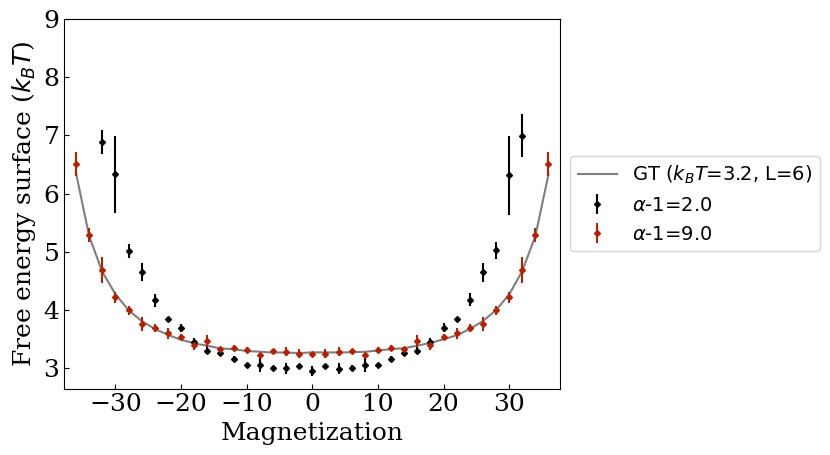

In [19]:
plot_magn(Pred_dict_c1, Reference_dict_latt6, 6, Reference_Tlist=[3.2], ylimit=(None,9))

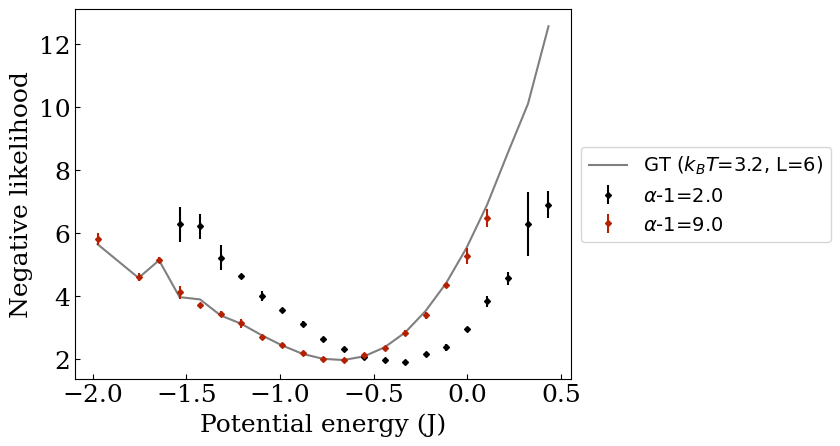

In [20]:
plot_potenergy(Pred_dict_c1, Reference_dict_potE_latt6, 6, Reference_Tlist=[3.2])

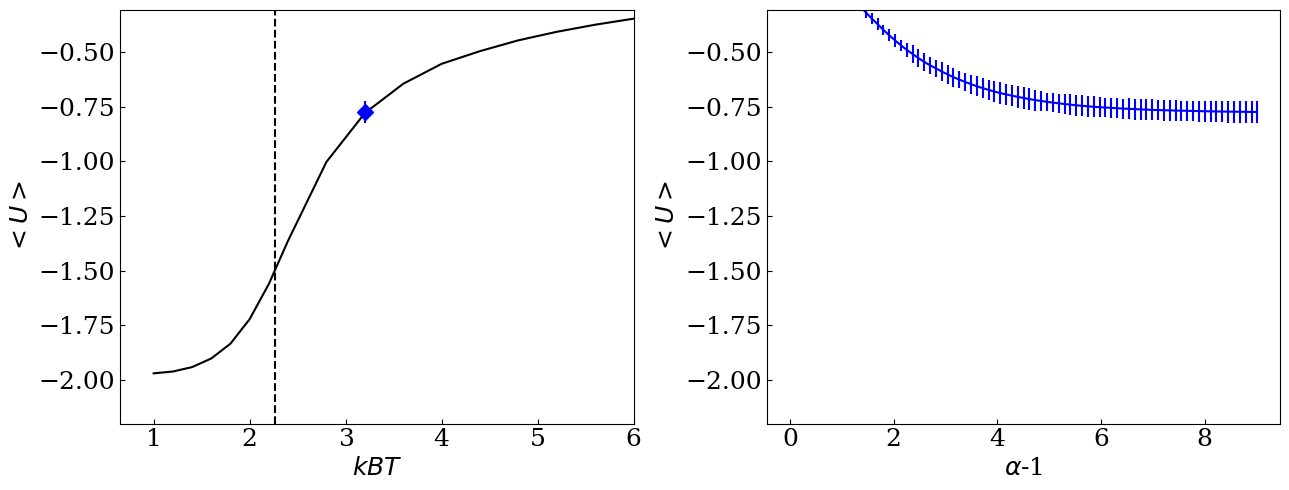

In [21]:
plot_expactation_potenergy(Pred_dict_c1, Expectation_Reference_dict_latt6, 6, Benchmark_T=[3.2,])

In [22]:
Pred_dict_ = {}

In [23]:
# Pred_dict_ = {}
Pred_dict_c1["seq_path"]="val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0/seq_val.npy"
T=3.2
L=6
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = None
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.0
Pred_dict_[key]["Predictions"] = Pred_dict_c1


In [24]:
Pred_dict_c0, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt1.0/g0", (6,6))
print(list(Pred_dict_c0["Flow-PotE"].keys()))
print(difftime_list)
calc_expectation_potenergy(Pred_dict_c0, difftime_list)


[0.0, 0.11267605633802824, 0.22535211267605626, 0.3380281690140845, 0.45070422535211274, 0.5633802816901408, 0.676056338028169, 0.7887323943661972, 0.9014084507042255, 1.0140845070422535, 1.1267605633802815, 1.23943661971831, 1.352112676056338, 1.464788732394366, 1.5774647887323945, 1.6901408450704225, 1.802816901408451, 1.915492957746479, 2.028169014084507, 2.1408450704225355, 2.2535211267605635, 2.3661971830985915, 2.47887323943662, 2.591549295774648, 2.704225352112676, 2.8169014084507045, 2.9295774647887325, 3.042253521126761, 3.154929577464789, 3.267605633802817, 3.380281690140845, 3.492957746478873, 3.605633802816902, 3.71830985915493, 3.830985915492958, 3.943661971830986, 4.056338028169014, 4.169014084507042, 4.281690140845071, 4.394366197183099, 4.507042253521127, 4.619718309859155, 4.732394366197183, 4.845070422535211, 4.957746478873239, 5.070422535211268, 5.183098591549296, 5.295774647887324, 5.408450704225352, 5.52112676056338, 5.633802816901408, 5.746478873239437, 5.85915492

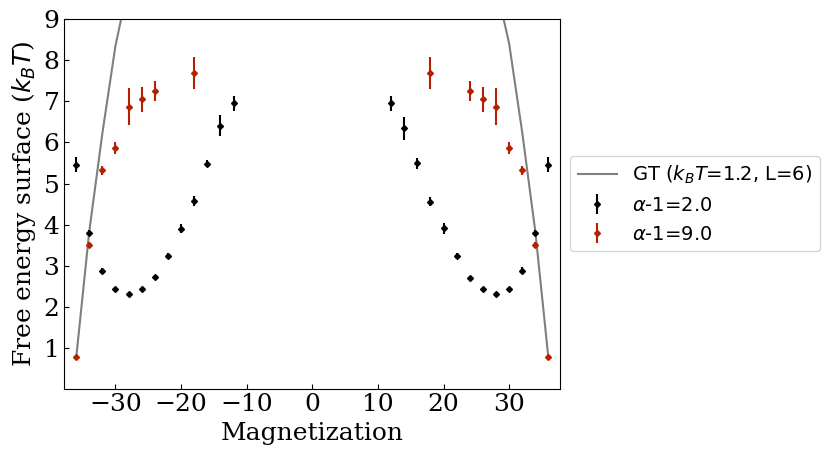

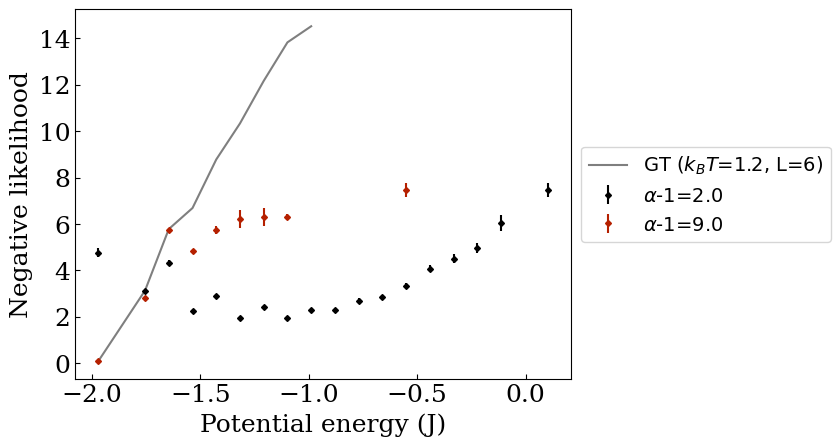

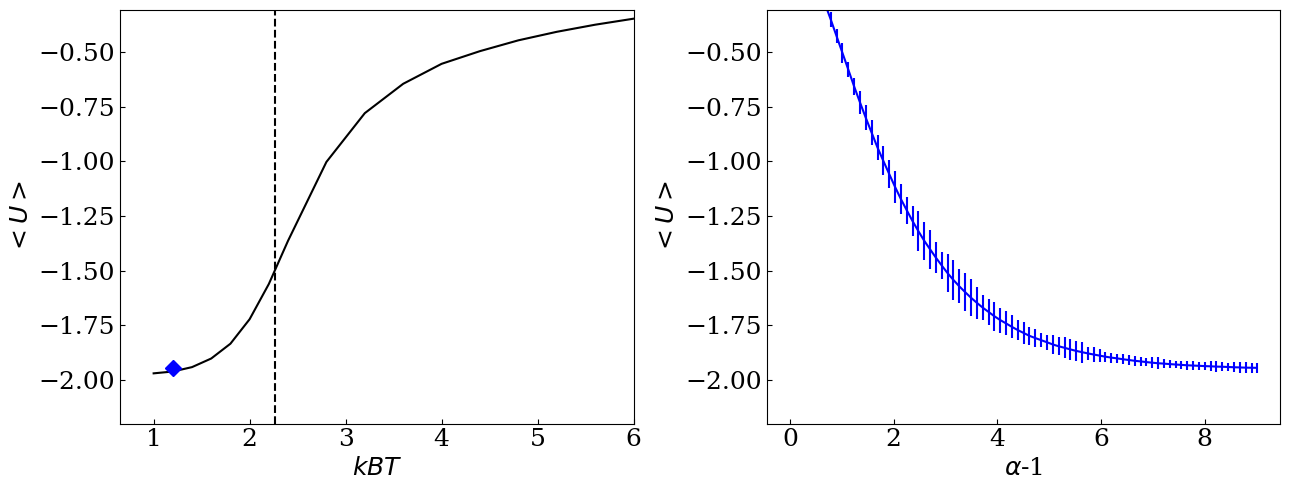

In [25]:
plot_magn(Pred_dict_c0, Reference_dict_latt6, 6, Reference_Tlist=[1.2], ylimit=(None,9))
plot_potenergy(Pred_dict_c0, Reference_dict_potE_latt6, 6, Reference_Tlist=[1.2])
plot_expactation_potenergy(Pred_dict_c0, Expectation_Reference_dict_latt6, 6, Benchmark_T=[1.2,])

In [26]:
Pred_dict_c0["seq_path"]="val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt1.0/g0/seq_val.npy"
T=1.2
L=6
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 1.0
Pred_dict_[key]["Predictions"] = Pred_dict_c0

In [27]:

Pred_dict_c2, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.1/g0", (6,6))
# Pred_dict_c2, difftime_list = read_prediction("mixT-combinedtraining/val_baseline_latt6x6/epoch243_IntStep640_AMax10_clsT2.4L6c_tilt_dfreq8_uncondm5/tilt1.0/g0", (6,6))
calc_expectation_potenergy(Pred_dict_c2, difftime_list)

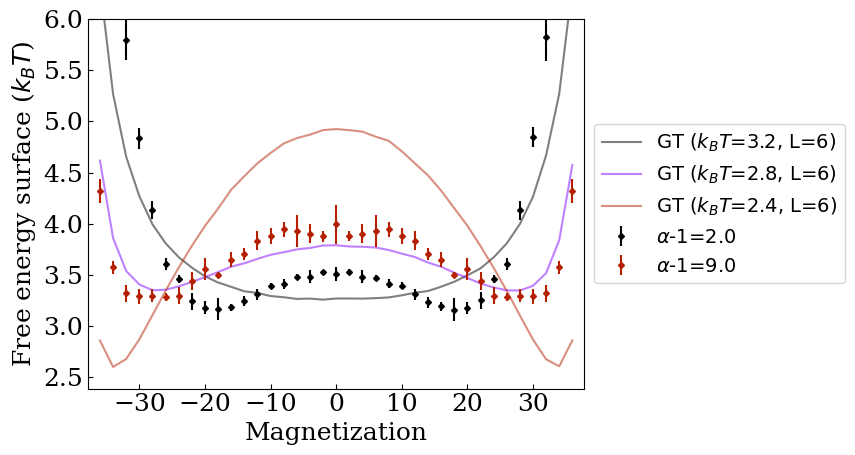

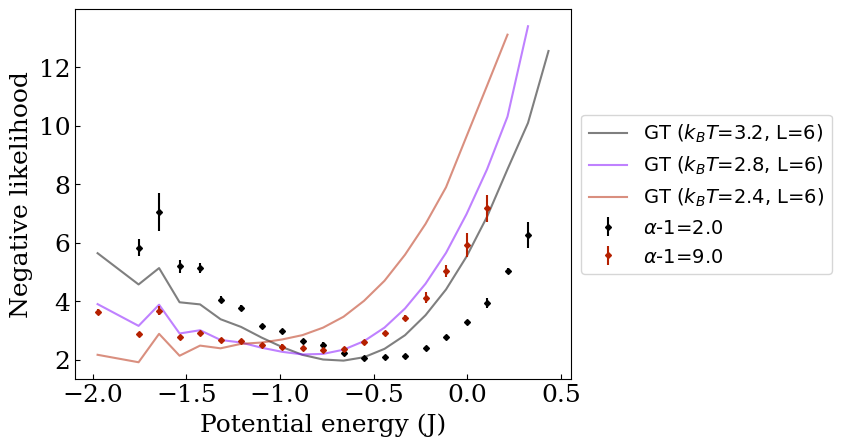

In [28]:
plot_magn(Pred_dict_c2, Reference_dict_latt6, 6, Reference_Tlist=[3.2, 2.8, 2.4])
plot_potenergy(Pred_dict_c2, Reference_dict_potE_latt6, 6, Reference_Tlist=[3.2, 2.8, 2.4])

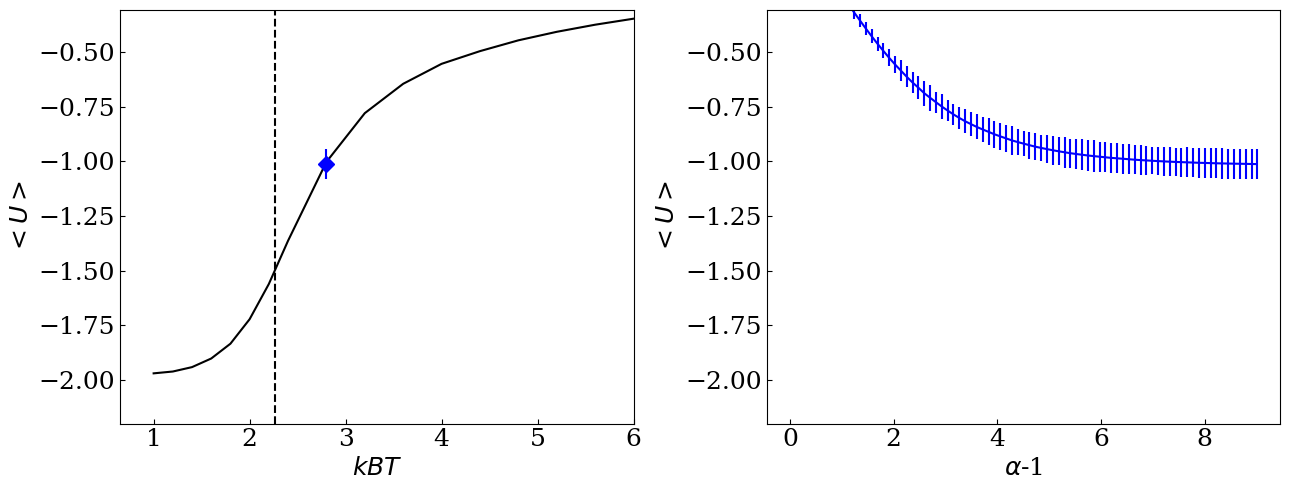

In [29]:
plot_expactation_potenergy(Pred_dict_c2, Expectation_Reference_dict_latt6, 6, Benchmark_T=[2.8], Benchmark_diffstep=[-1])

In [30]:
T=2.8
L=6
key="T%.1fL%d"%(T,L)
Pred_dict_c2["seq_path"] = "val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.1/g0/seq_val.npy"
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.1
Pred_dict_[key]["Predictions"] = Pred_dict_c2

In [31]:
Pred_dict_c3, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0", (6,6))
calc_expectation_potenergy(Pred_dict_c3, difftime_list)

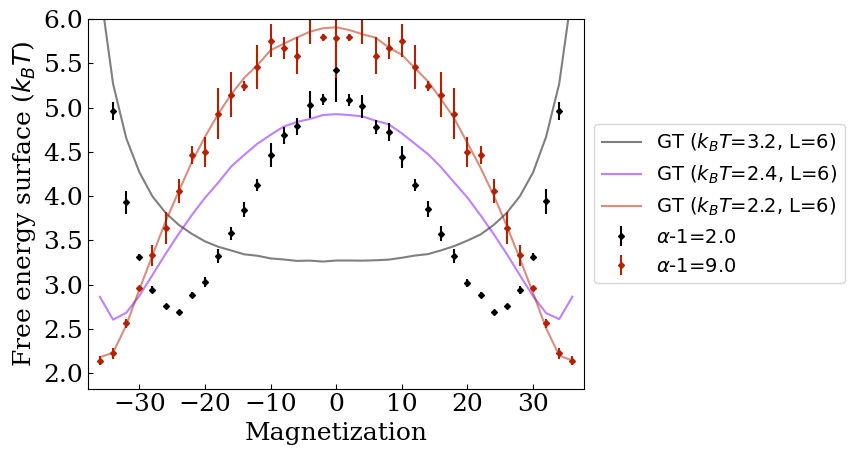

In [32]:
plot_magn(Pred_dict_c3, Reference_dict_latt6, 6, Reference_Tlist=[3.2, 2.4, 2.2])

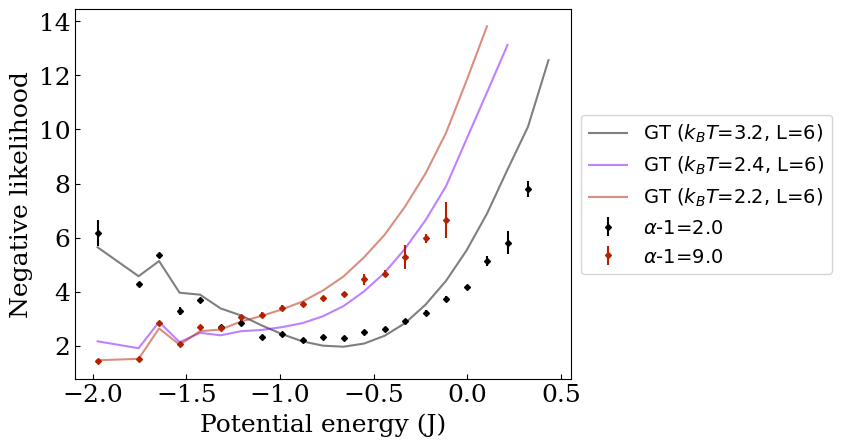

In [33]:
plot_potenergy(Pred_dict_c3, Reference_dict_potE_latt6, 6, Reference_Tlist=[3.2, 2.4, 2.2])

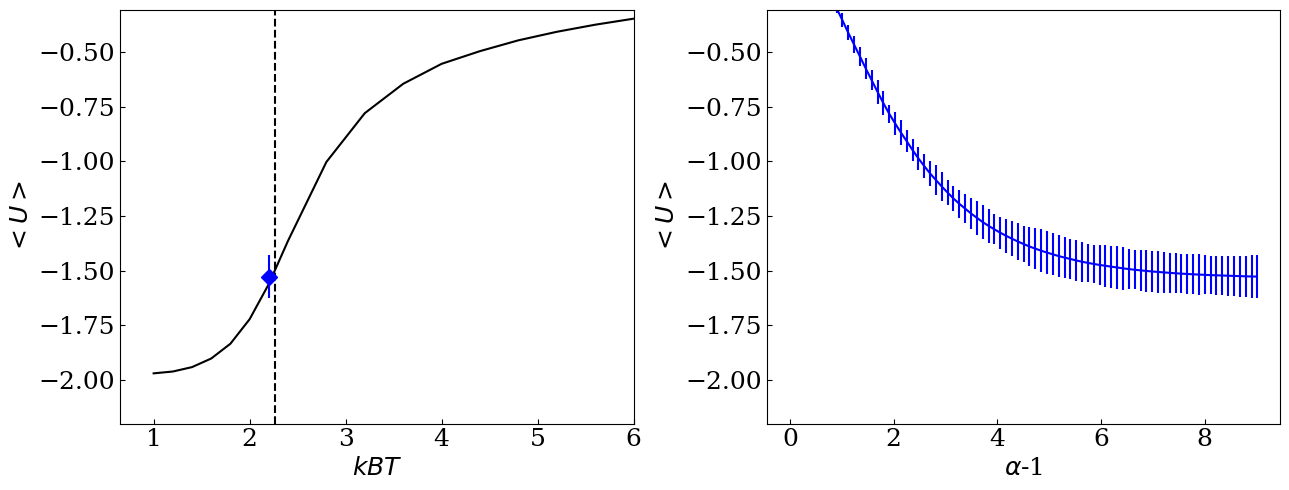

In [34]:
plot_expactation_potenergy(Pred_dict_c3, Expectation_Reference_dict_latt6, 6, Benchmark_T=[2.2], Benchmark_diffstep=[-1])

In [35]:
T=2.2
L=6
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_c3["seq_path"] = "val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0/seq_val.npy"
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.24
Pred_dict_[key]["Predictions"] = Pred_dict_c3

In [36]:
Pred_dict_c5, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.5/g0", (6,6))
calc_expectation_potenergy(Pred_dict_c5, difftime_list)

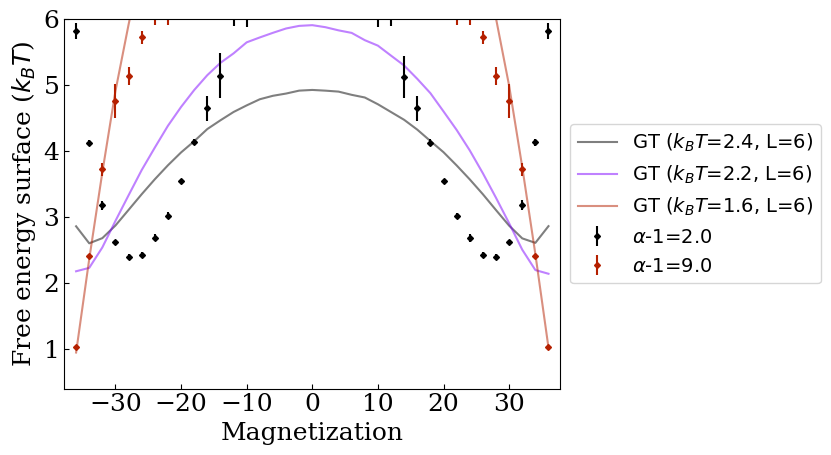

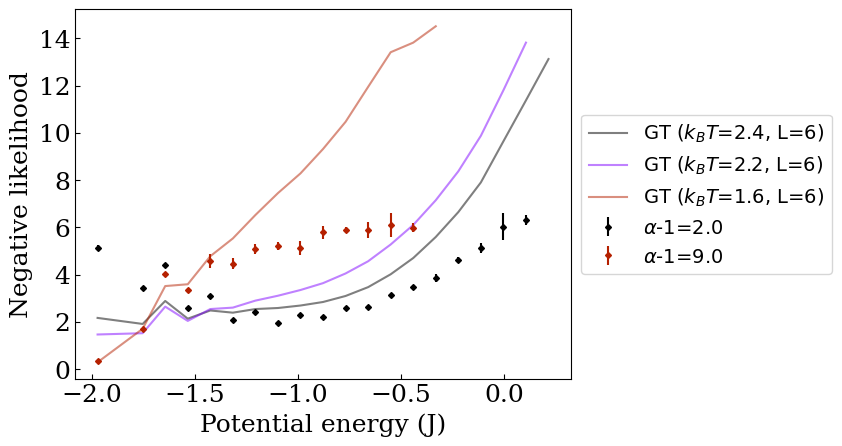

In [37]:
plot_magn(Pred_dict_c5, Reference_dict_latt6, 6, Reference_Tlist=[2.4, 2.2, 1.6])
plot_potenergy(Pred_dict_c5, Reference_dict_potE_latt6, 6, Reference_Tlist=[2.4, 2.2, 1.6])

In [38]:
Pred_dict_c4, difftime_list = read_prediction("val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0", (6,6))
calc_expectation_potenergy(Pred_dict_c4, difftime_list)

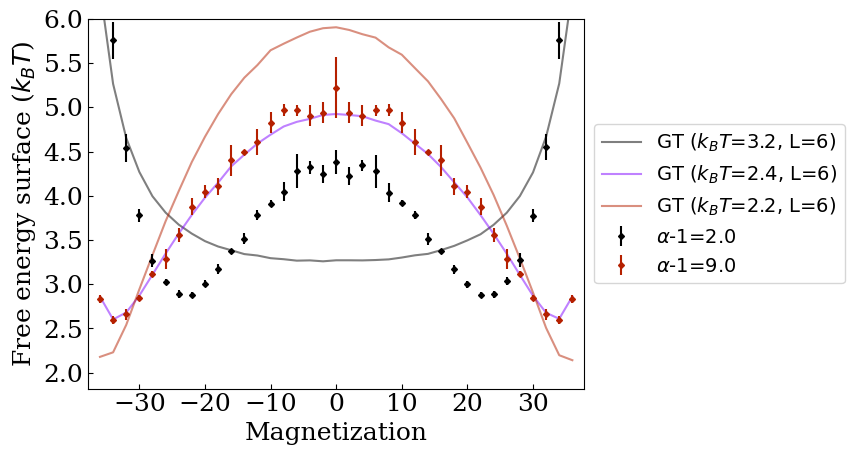

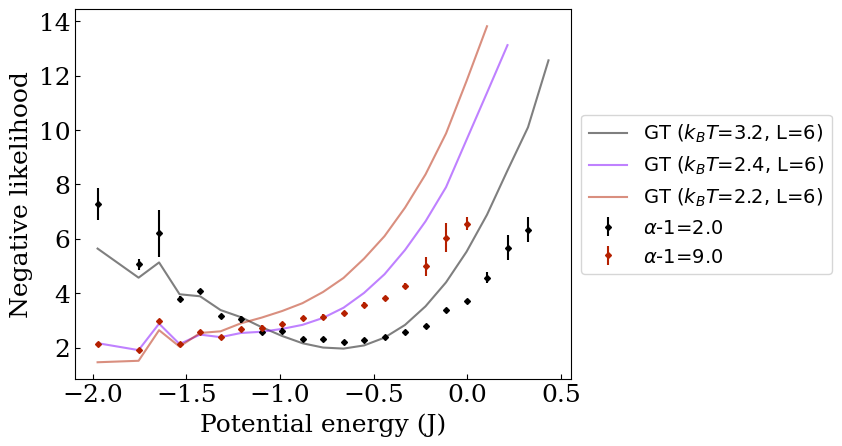

In [39]:
plot_magn(Pred_dict_c4, Reference_dict_latt6, 6, Reference_Tlist=[3.2, 2.4, 2.2])
plot_potenergy(Pred_dict_c4, Reference_dict_potE_latt6, 6, Reference_Tlist=[3.2, 2.4, 2.2])

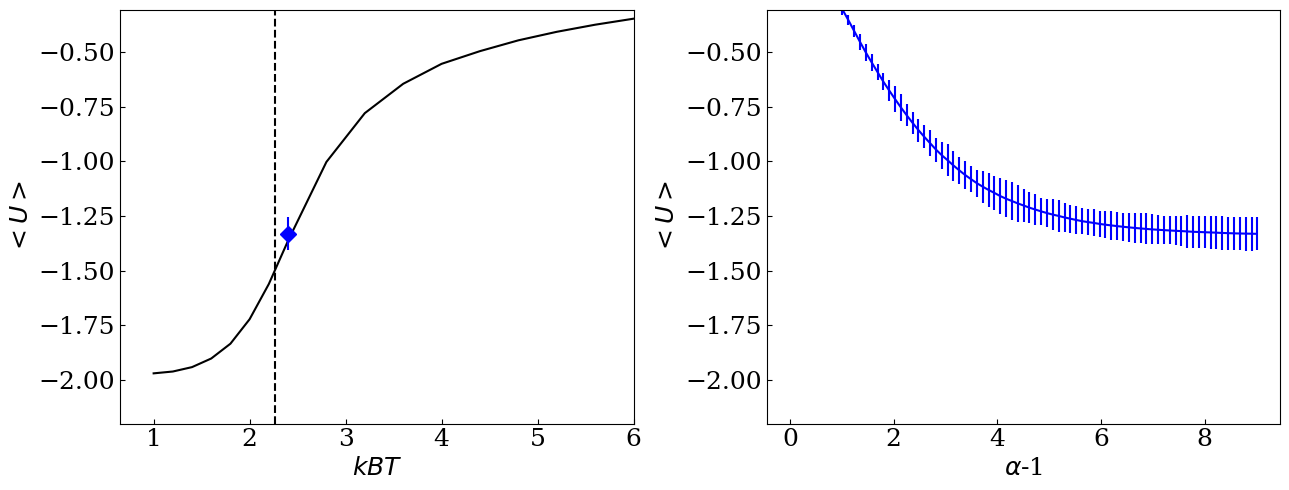

In [40]:
plot_expactation_potenergy(Pred_dict_c4, Expectation_Reference_dict_latt6, 6, Benchmark_T=[2.4], Benchmark_diffstep=[-1])

In [41]:
T=2.4
L=6
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_c4["seq_path"] = "val_baseline_latt6x6/epoch209_IntStep640_AMax10_clsT2.8L6c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0/seq_val.npy"
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.18
Pred_dict_[key]["Predictions"] = Pred_dict_c4


In [42]:
for k in sorted(list(Pred_dict_.keys())):
    print(k, Pred_dict_[k]["guidance_coeff"])

T1.2L6 1.0
T2.2L6 0.24
T2.4L6 0.18
T2.8L6 0.1
T3.2L6 0.0


## Lattice size = 12x12

In [43]:
0.25*2.2/2.4, 0.25*2.2/2.8

(0.22916666666666669, 0.19642857142857145)

In [44]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(12,12,12,12)
Reference_dict_latt12 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt12 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))
Expectation_Reference_dict_latt12 = {}
Expectation_Reference_dict_latt12["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [45]:
Pred_dict_c0_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0", (12,12))
calc_expectation_potenergy(Pred_dict_c0_latt12, difftime_list)

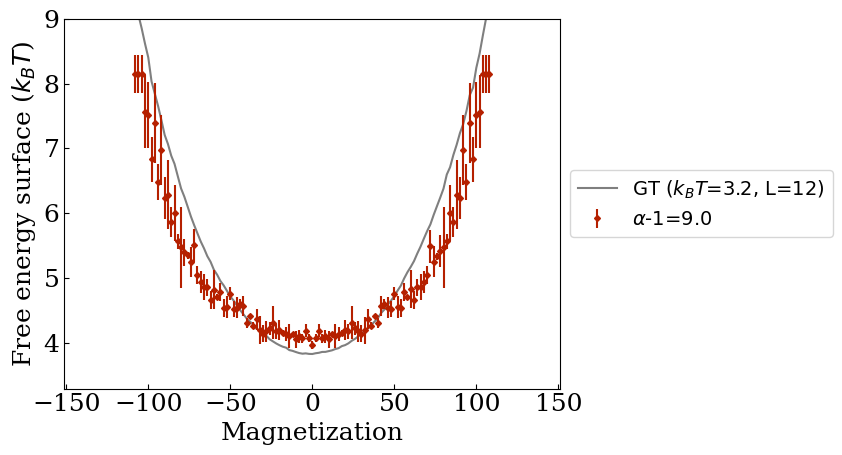

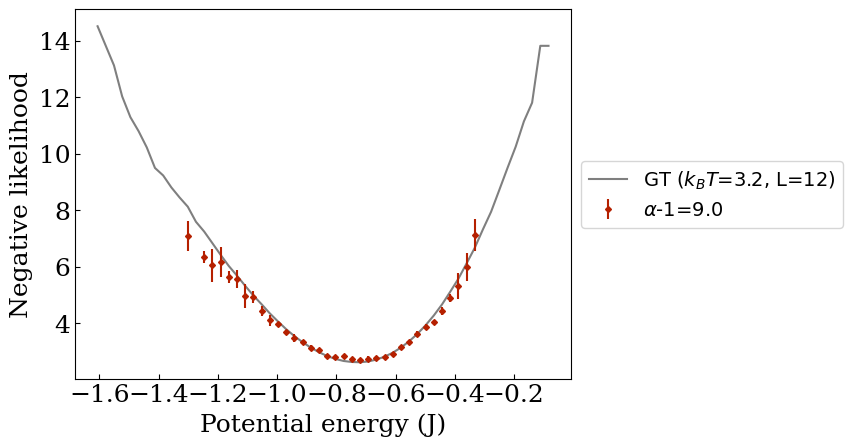

In [46]:
plot_magn(Pred_dict_c0_latt12, Reference_dict_latt12, 12, Reference_Tlist=[3.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c0_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[3.2], diffstep_list=[-1])

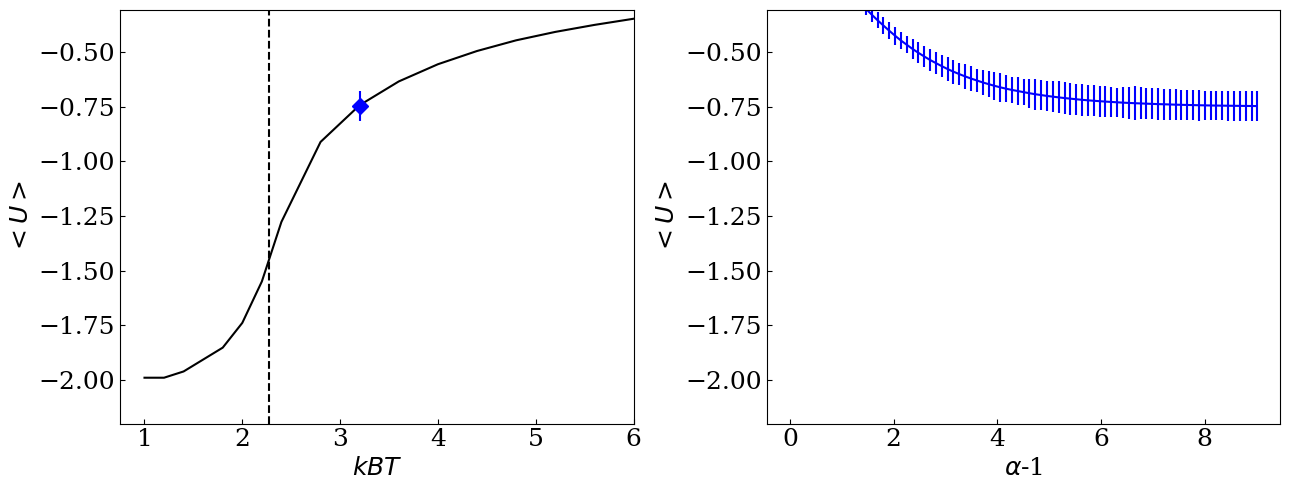

In [47]:
plot_expactation_potenergy(Pred_dict_c0_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[3.2,], Benchmark_diffstep=[-1])

In [48]:
Pred_dict_c0_latt12["seq_path"] = "val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0/seq_val.npy"
T=3.2
L=12
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = None
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.0
Pred_dict_[key]["Predictions"] = Pred_dict_c0_latt12

In [49]:
# Pred_dict_c1_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.2L12c_scoreG0.55_dfreq8_uncondm2/g0", (12,12))
Pred_dict_c1_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0", (12,12))

In [50]:
calc_expectation_potenergy(Pred_dict_c1_latt12, difftime_list)

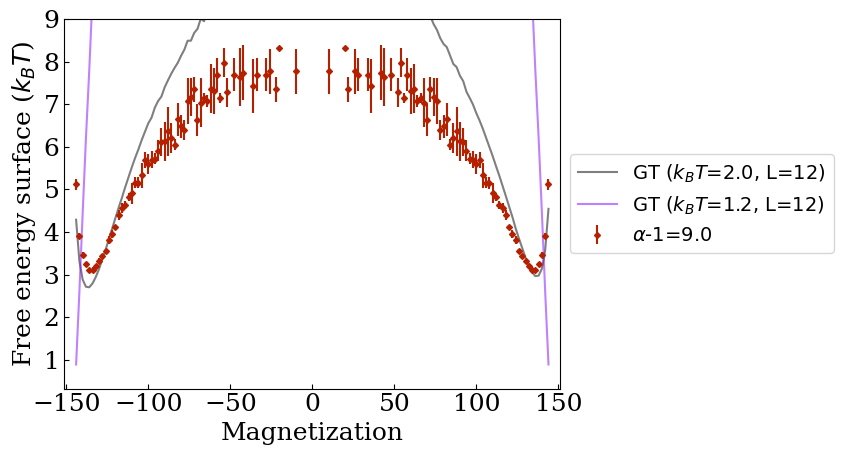

In [51]:
plot_magn(Pred_dict_c1_latt12, Reference_dict_latt12, 12, Reference_Tlist=[2.0, 1.2], diffstep_list=[-1], ylimit=(None, 9))

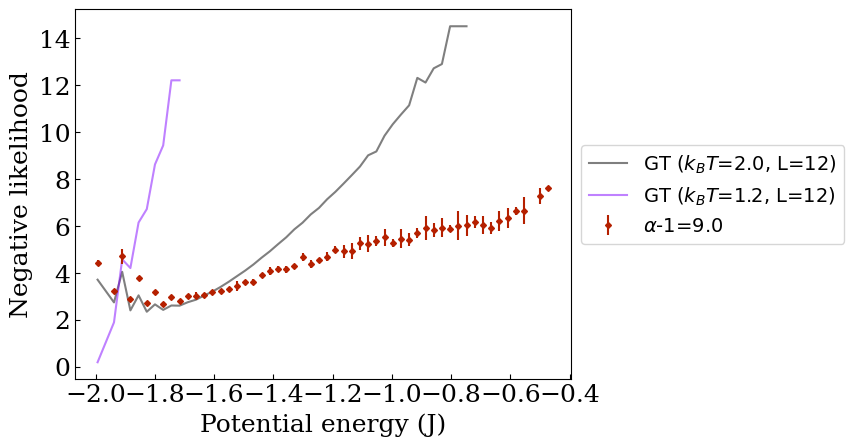

In [52]:
plot_potenergy(Pred_dict_c1_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[2.0, 1.2], diffstep_list=[-1])

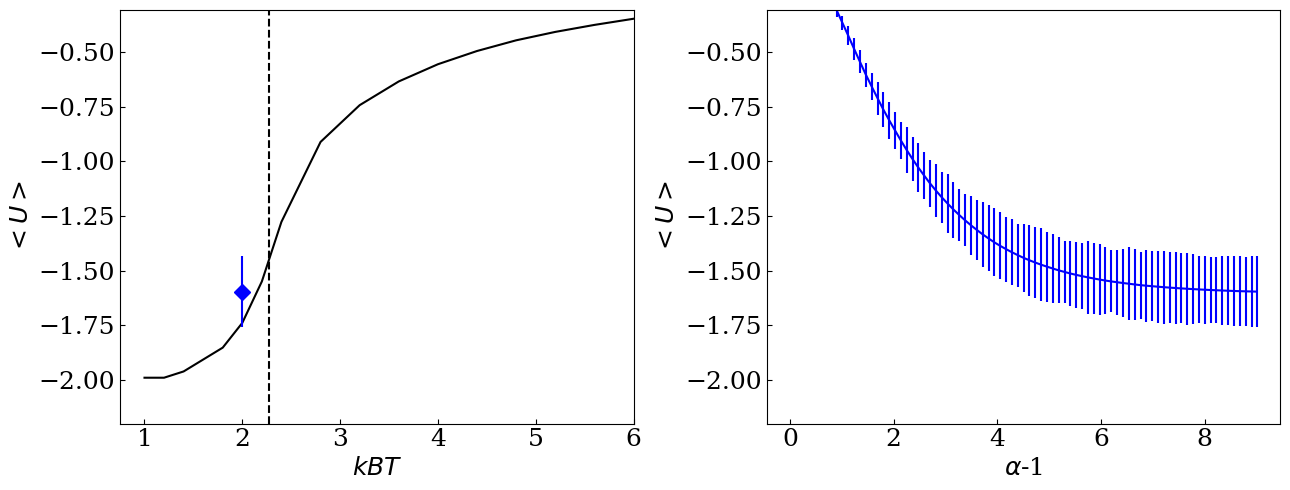

In [53]:
plot_expactation_potenergy(Pred_dict_c1_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[2.0,], Benchmark_diffstep=[-1])

In [54]:
Pred_dict_c1_latt12["seq_path"] = "val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0/seq_val.npy"
T=2.
L=12
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.24
Pred_dict_[key]["Predictions"] = Pred_dict_c1_latt12

In [55]:
# Pred_dict_c2_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.02/g0", (12,12))
# calc_expectation_potenergy(Pred_dict_c2_latt12, difftime_list)

In [56]:
# plot_magn(Pred_dict_c2_latt12, Reference_dict_latt12, 12, Reference_Tlist=[3.0], diffstep_list=[-1], ylimit=(None, 9))

In [57]:
# plot_potenergy(Pred_dict_c2_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[2.8], diffstep_list=[-1])

In [58]:
# plot_expactation_potenergy(Pred_dict_c2_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[2.9,], Benchmark_diffstep=[-1])

In [59]:
# plot_dist("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.04/g0")

In [60]:
# Pred_dict_c2_latt12["seq_path"] = "val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.04/g0/seq_val.npy"
# T=2.9
# L=12
# key="T%.1fL%d"%(T,L)
# Pred_dict_[key] = {}
# Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
# Pred_dict_[key]["shuffle_freq"] = 0.0
# Pred_dict_[key]["guidance_coeff"] = 0.04
# Pred_dict_[key]["Predictions"] = Pred_dict_c2_latt12

In [61]:
# Pred_dict_c3_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.06/g0", (12,12))
Pred_dict_c3_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch349_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.75/g0", (12,12))

calc_expectation_potenergy(Pred_dict_c3_latt12, difftime_list)

FileNotFoundError: [Errno 2] No such file or directory: 'val_baseline_latt12x12/epoch349_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.75/g0/FES-MAGN.dat'

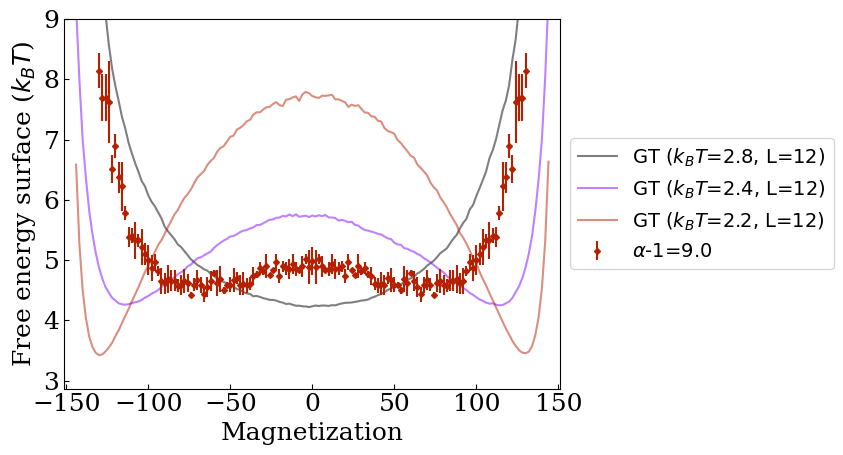

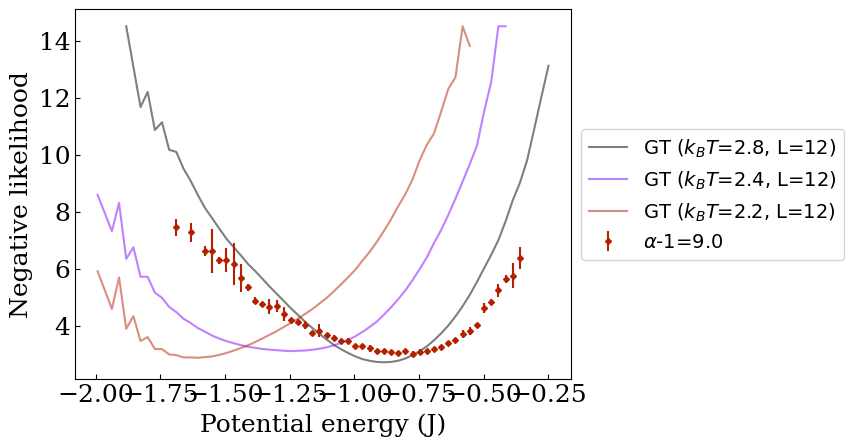

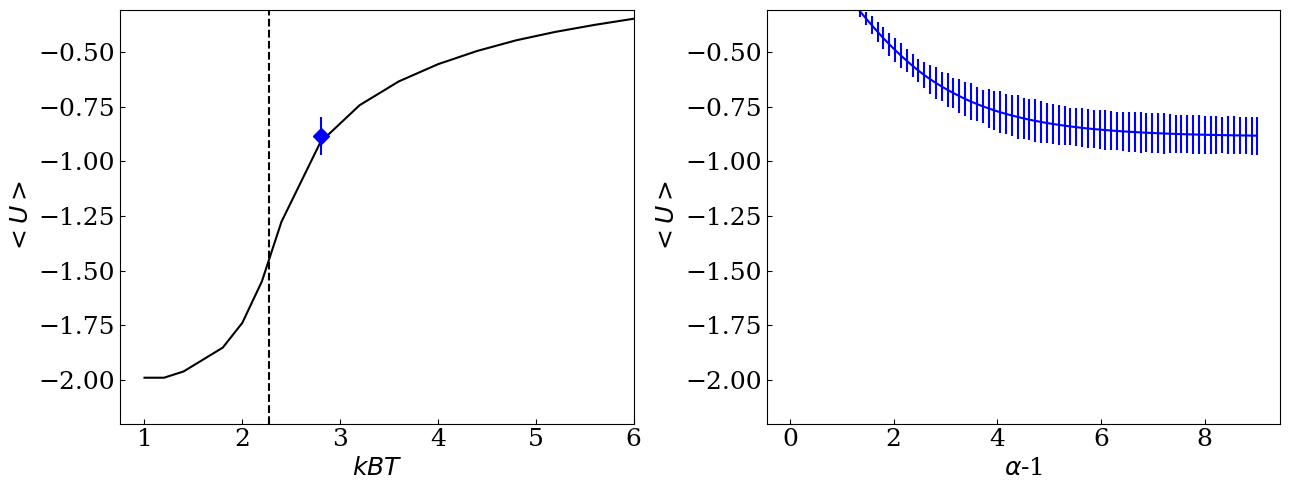

In [121]:
plot_magn(Pred_dict_c3_latt12, Reference_dict_latt12, 12, Reference_Tlist=[2.8, 2.4, 2.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c3_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[2.8, 2.4, 2.2], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c3_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[2.8,], Benchmark_diffstep=[-1])

In [163]:
Pred_dict_c4_latt12, difftime_list = read_prediction("val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.2/g0", (12,12))
calc_expectation_potenergy(Pred_dict_c4_latt12, difftime_list)

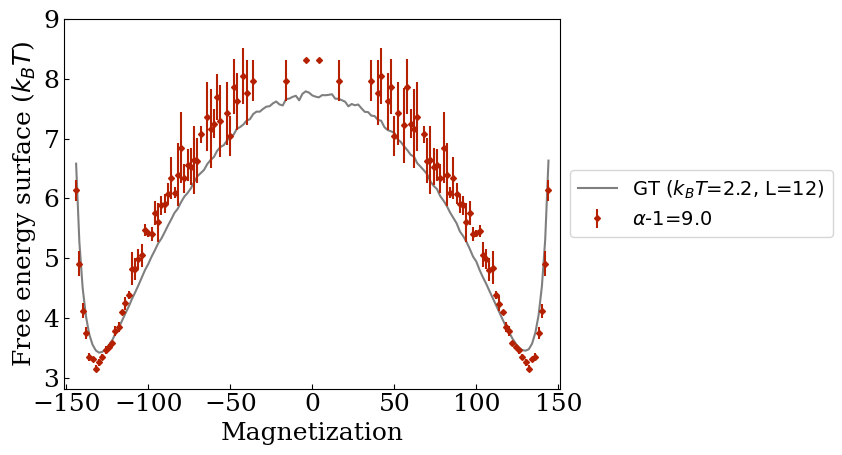

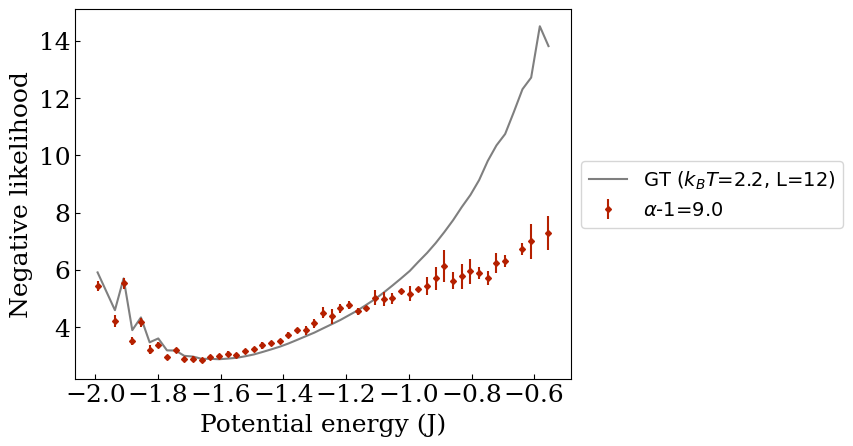

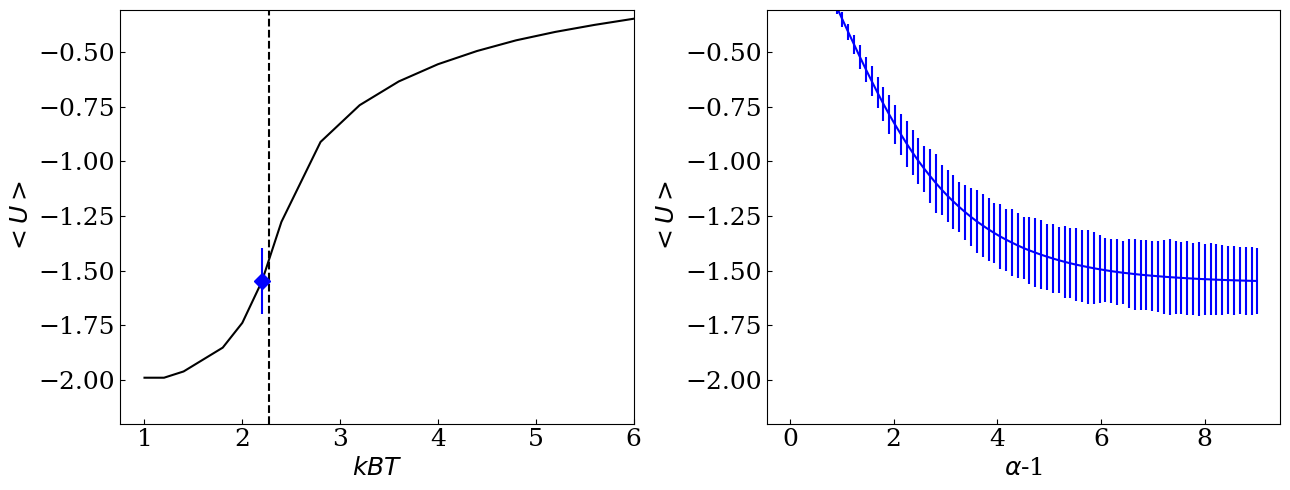

In [164]:
plot_magn(Pred_dict_c4_latt12, Reference_dict_latt12, 12, Reference_Tlist=[2.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c4_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[2.2], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c4_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[2.2,], Benchmark_diffstep=[-1])

In [167]:
Pred_dict_c4_latt12["seq_path"] = "val_baseline_latt12x12/epoch209_IntStep640_AMax10_clsT2.8L12c_tilt0.25_dfreq8_uncondm5/tilt0.2/g0/seq_val.npy"
T=2.2
L=12
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.2, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.2
Pred_dict_[key]["Predictions"] = Pred_dict_c4_latt12

([], [])

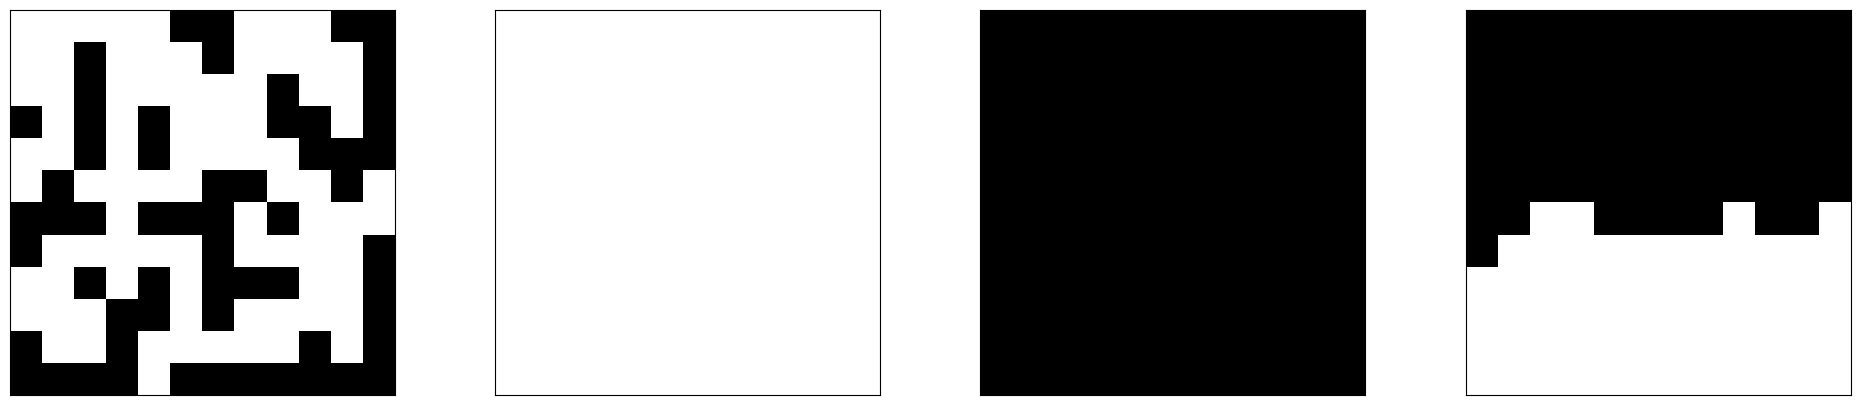

In [73]:
plt.figure(figsize=(24,5))
plt.subplot(141)
r1 = np.random.choice([-1,1], size=(12,12))
_ = plt.imshow(r1, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(142)
r2 = np.ones((12,12))*-1
_ = plt.imshow(r2, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(143)
r3 = np.ones((12,12))
_ = plt.imshow(r3, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(144)
r4 = np.ones((12,12))*-1
for i in range(12):
    for j in range(12):
        rboundary = np.random.rand()*0.2+0.4
        if i < rboundary*12:
            r4[i,j]=1

_ = plt.imshow(r4, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])



In [434]:
'''
for k in list(Pred_dict_.keys()):
    if "18" in k:
        del Pred_dict_[k]
    if "24" in k:
        del Pred_dict_[k]
'''


'\nfor k in list(Pred_dict_.keys()):\n    if "18" in k:\n        del Pred_dict_[k]\n    if "24" in k:\n        del Pred_dict_[k]\n'

In [168]:
for key in sorted(list(Pred_dict_.keys())):
    print(key, Pred_dict_[key]["guidance_coeff"])

T1.2L12 1.0
T1.2L24 1.0
T1.2L6 1.0
T2.2L12 0.2
T2.2L24 0.18
T2.2L6 0.24
T2.4L12 0.14
T2.4L6 0.18
T2.8L6 0.1
T3.2L12 0.0
T3.2L24 0.0
T3.2L6 0.0


## Lattice size = 18x18

In [169]:
L=18
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(L,L,L,L)
Reference_dict_latt18 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt18 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))
Expectation_Reference_dict_latt18 = {}
Expectation_Reference_dict_latt18["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [170]:
Pred_dict_c3_latt18, difftime_list = read_prediction("val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0", (18,18))
calc_expectation_potenergy(Pred_dict_c3_latt18, difftime_list)

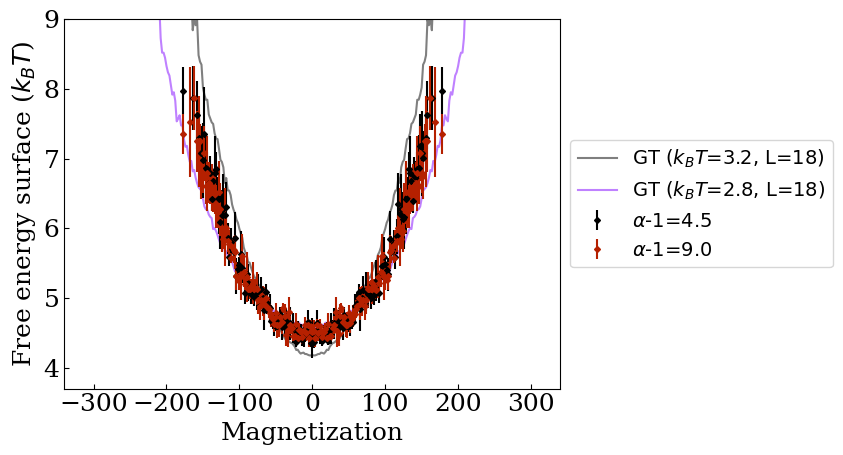

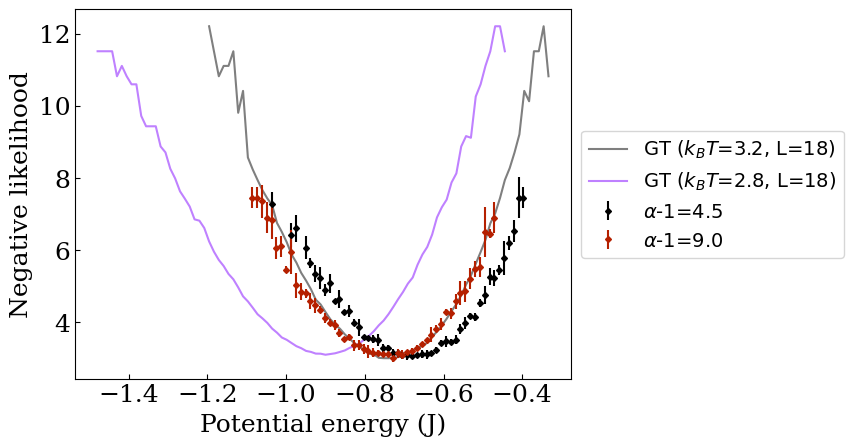

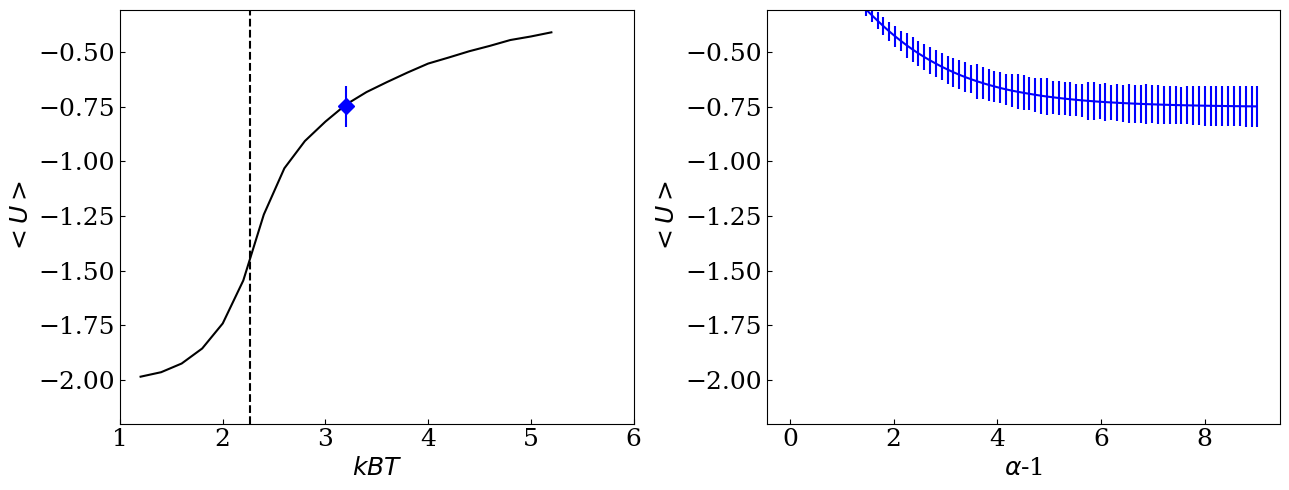

In [171]:
plot_magn(Pred_dict_c3_latt18, Reference_dict_latt18, 18, Reference_Tlist=[3.2, 2.8], diffstep_list=[40, -1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c3_latt18, Reference_dict_potE_latt18, 18, Reference_Tlist=[3.2, 2.8], diffstep_list=[40, -1])
plot_expactation_potenergy(Pred_dict_c3_latt18, Expectation_Reference_dict_latt18, 18, Benchmark_T=[3.2,], Benchmark_diffstep=[-1])

In [172]:
Pred_dict_c3_latt18["seq_path"] = "val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0/seq_val.npy"
T=3.2
L=18
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = None
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.0
Pred_dict_[key]["Predictions"] = Pred_dict_c3_latt18

In [173]:
Pred_dict_c0_latt18, difftime_list = read_prediction("val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt1.0/g0", (18,18))
calc_expectation_potenergy(Pred_dict_c0_latt18, difftime_list)

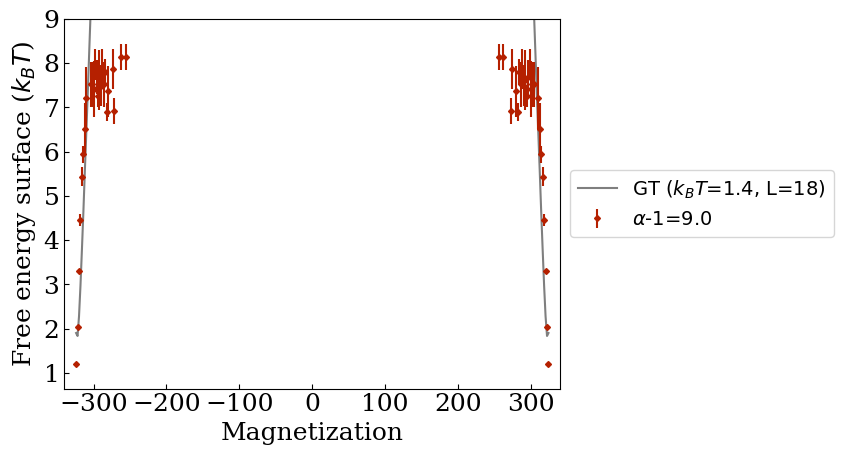

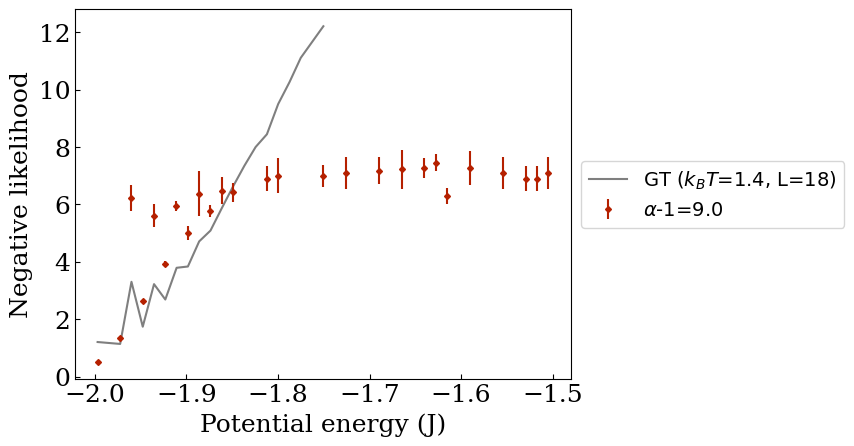

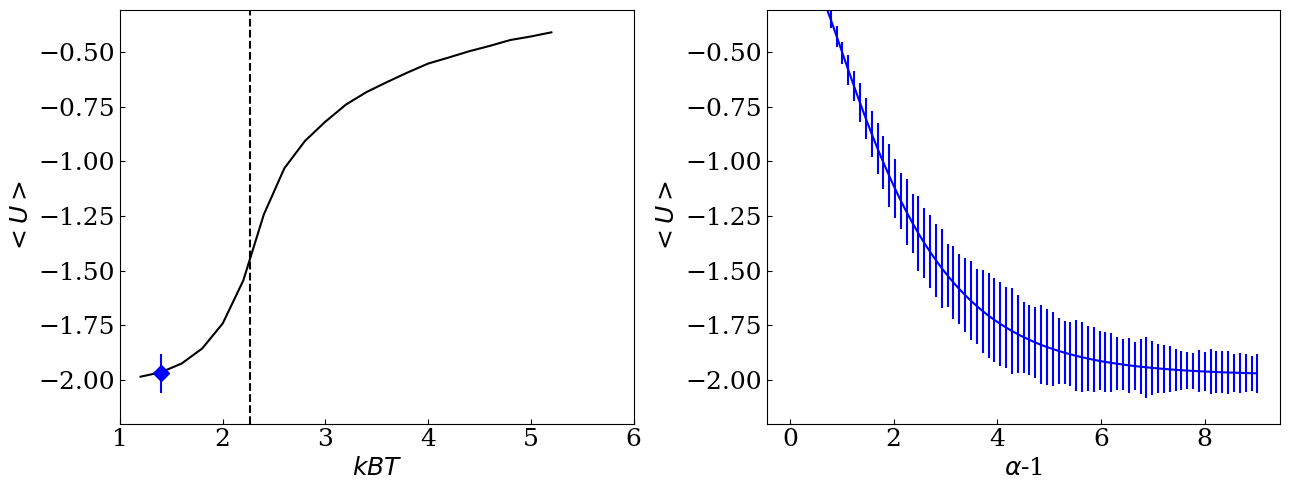

In [174]:
plot_magn(Pred_dict_c0_latt18, Reference_dict_latt18, 18, Reference_Tlist=[1.4], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c0_latt18, Reference_dict_potE_latt18, 18, Reference_Tlist=[1.4], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c0_latt18, Expectation_Reference_dict_latt18, 18, Benchmark_T=[1.4,], Benchmark_diffstep=[-1])

In [175]:
Pred_dict_c0_latt18["seq_path"] = "val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt1.0/g0/seq_val.npy"
T=1.2
L=18
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 1.0
Pred_dict_[key]["Predictions"] = Pred_dict_c0_latt18

In [204]:
Pred_dict_c1_latt18, difftime_list = read_prediction("val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.5/g0", (18,18))
# Pred_dict_c1_latt18, difftime_list = read_prediction("mixT/val_baseline_latt18x18/epoch560_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm3/tilt0.06/g0", (18,18))
calc_expectation_potenergy(Pred_dict_c1_latt18, difftime_list)

FileNotFoundError: [Errno 2] No such file or directory: 'val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.5/g0/FES-MAGN.dat'

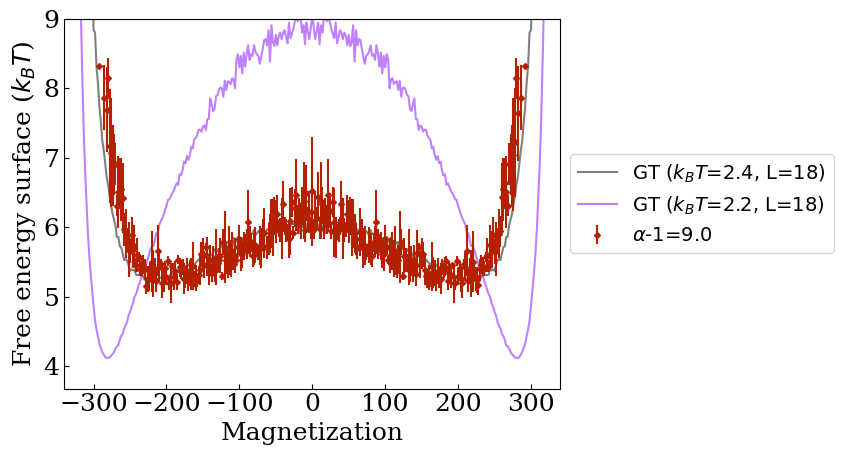

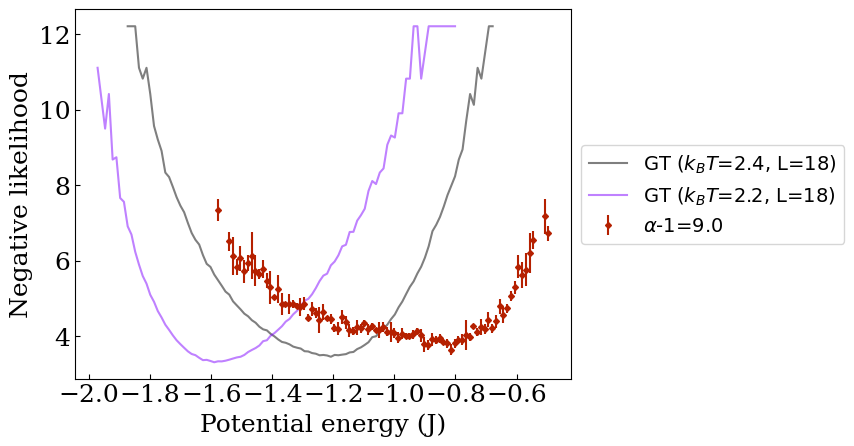

In [203]:
plot_magn(Pred_dict_c1_latt18, Reference_dict_latt18, 18, Reference_Tlist=[2.4, 2.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c1_latt18, Reference_dict_potE_latt18, 18, Reference_Tlist=[2.4, 2.2], diffstep_list=[-1])

seq.shape =  16384 18 18
6425


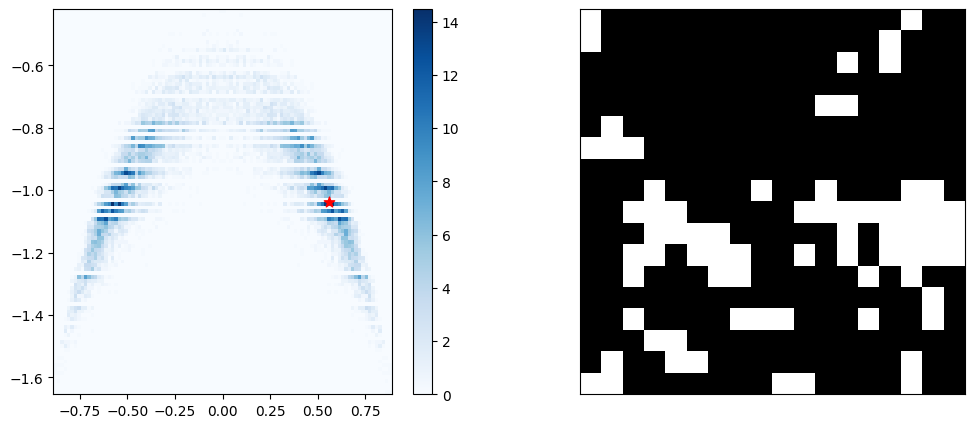

In [189]:
plot_dist("val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.08/g0")

In [ ]:
plot_expactation_potenergy(Pred_dict_c1_latt18, Expectation_Reference_dict_latt18, 18, Benchmark_T=[2.4,], Benchmark_diffstep=[-1])

In [177]:
Pred_dict_c2_latt18, difftime_list = read_prediction("val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0", (18,18))
calc_expectation_potenergy(Pred_dict_c2_latt18, difftime_list)

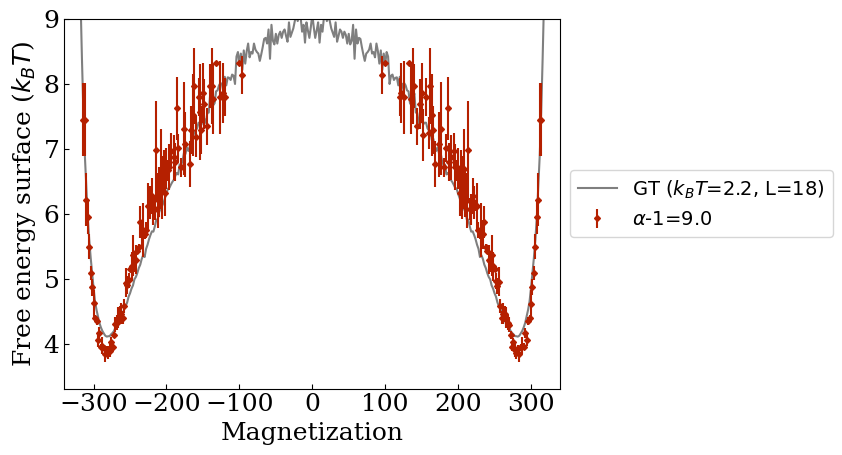

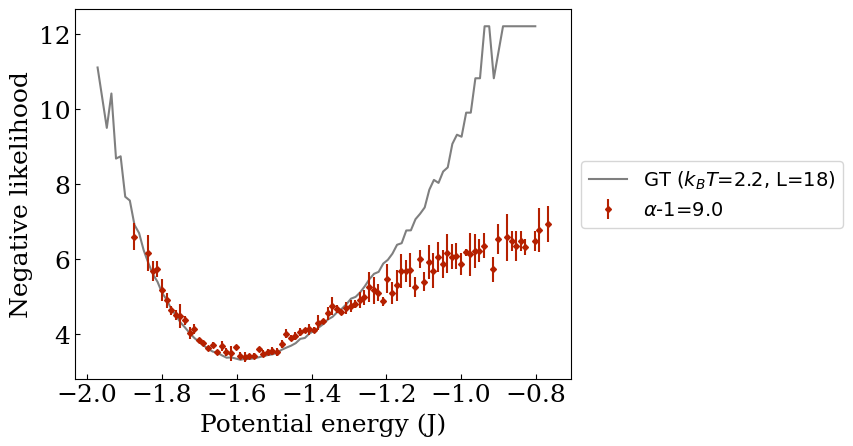

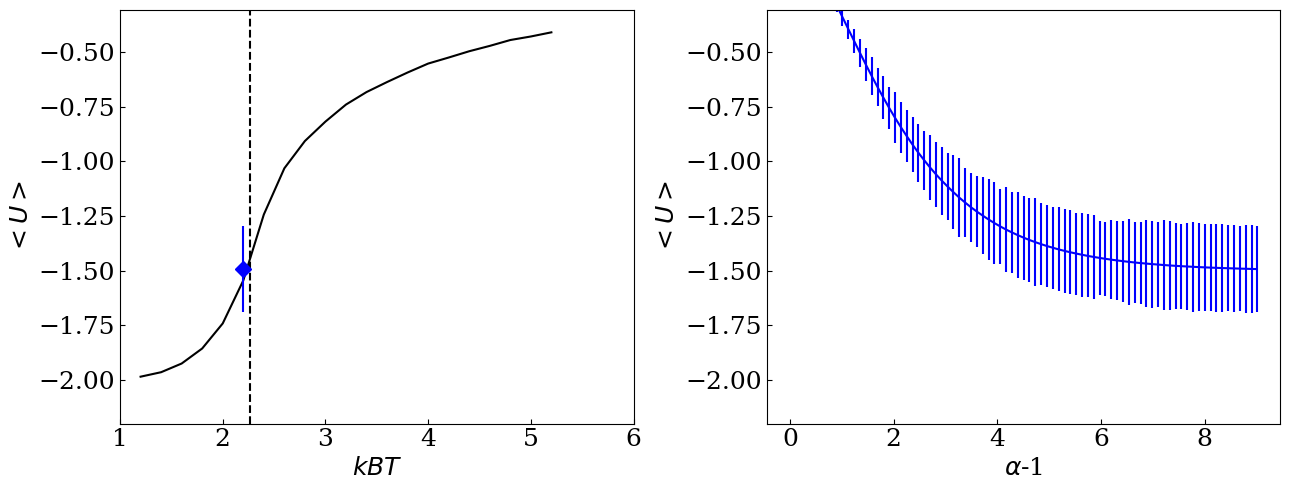

In [178]:
plot_magn(Pred_dict_c2_latt18, Reference_dict_latt18, 18, Reference_Tlist=[2.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c2_latt18, Reference_dict_potE_latt18, 18, Reference_Tlist=[2.2], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c2_latt18, Expectation_Reference_dict_latt18, 18, Benchmark_T=[2.2,], Benchmark_diffstep=[-1])

In [179]:
Pred_dict_c2_latt18["seq_path"] = "val_baseline_latt18x18/epoch209_IntStep640_AMax10_clsT2.8L18c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0/seq_val.npy"
T=2.2
L=18
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.2, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.18
Pred_dict_[key]["Predictions"] = Pred_dict_c2_latt18

In [180]:
for key in sorted(list(Pred_dict_.keys())):
    print(key, Pred_dict_[key]["guidance_coeff"])

T1.2L12 1.0
T1.2L18 1.0
T1.2L24 1.0
T1.2L6 1.0
T2.2L12 0.2
T2.2L18 0.18
T2.2L24 0.18
T2.2L6 0.24
T2.4L12 0.14
T2.4L6 0.18
T2.8L6 0.1
T3.2L12 0.0
T3.2L18 0.0
T3.2L24 0.0
T3.2L6 0.0


## Lattice size = 24x24

In [62]:
L=24
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(L,L,L,L)
Reference_dict_latt24 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt24 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))
Expectation_Reference_dict_latt24 = {}
Expectation_Reference_dict_latt24["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [63]:
Pred_dict_c0_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt1.0/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c0_latt24, difftime_list)

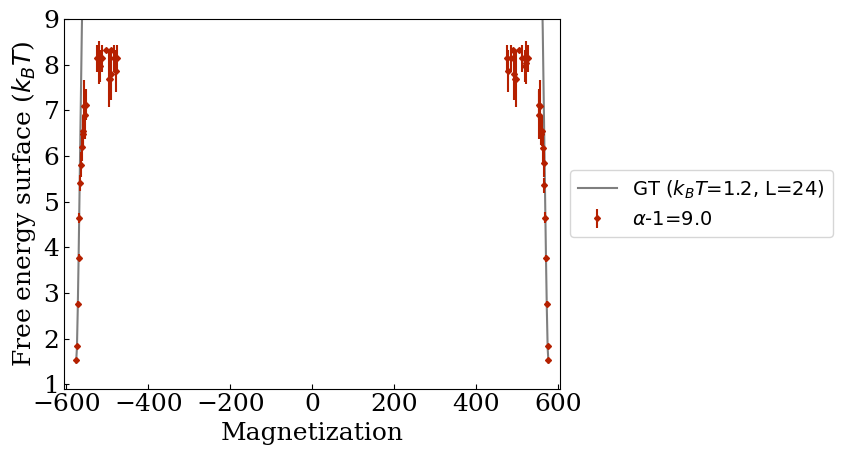

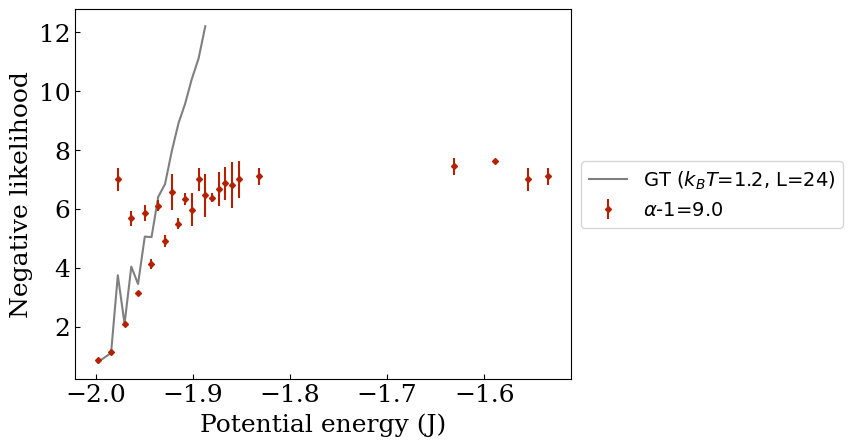

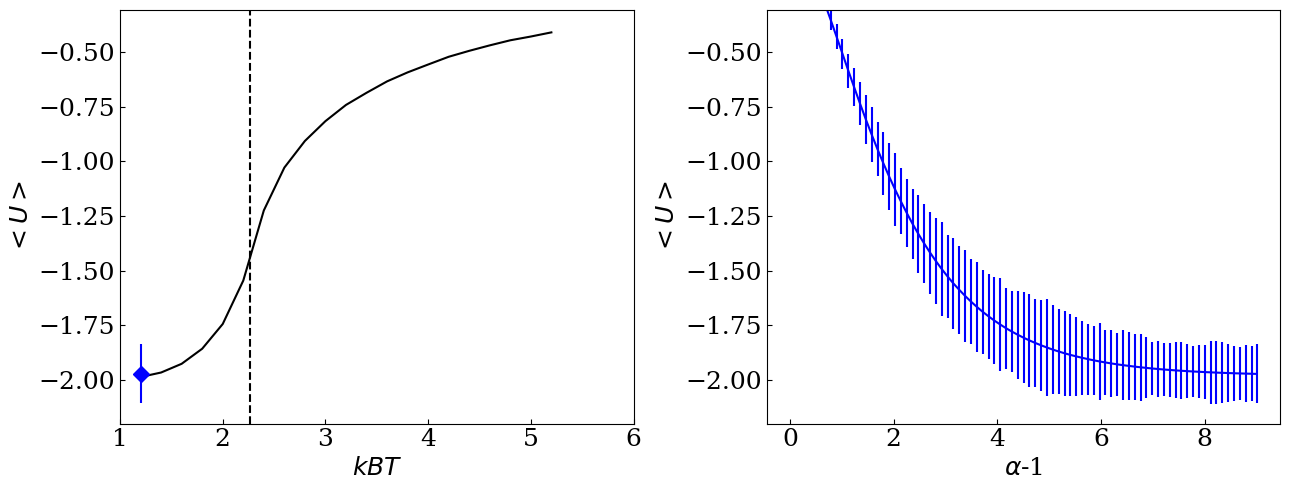

In [64]:
plot_magn(Pred_dict_c0_latt24, Reference_dict_latt24, 24, Reference_Tlist=[1.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c0_latt24, Reference_dict_potE_latt24, 24, Reference_Tlist=[1.2], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c0_latt24, Expectation_Reference_dict_latt24, 24, Benchmark_T=[1.2,], Benchmark_diffstep=[-1])

In [65]:
Pred_dict_c0_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm3/tilt1.0/g0/seq_val.npy"
T=1.2
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 1.0
Pred_dict_[key]["Predictions"] = Pred_dict_c0_latt24

In [66]:

Pred_dict_c5_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.75/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c5_latt24, difftime_list)

In [67]:
Pred_dict_c5_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm3/tilt0.75/g0/seq_val.npy"
T=1.4
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 1.4
Pred_dict_[key]["Predictions"] = Pred_dict_c5_latt24

In [69]:

Pred_dict_c5_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.026/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c5_latt24, difftime_list)

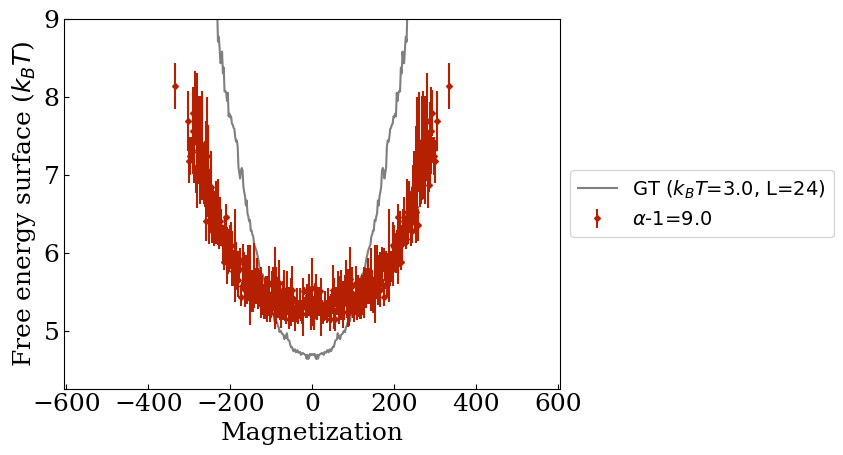

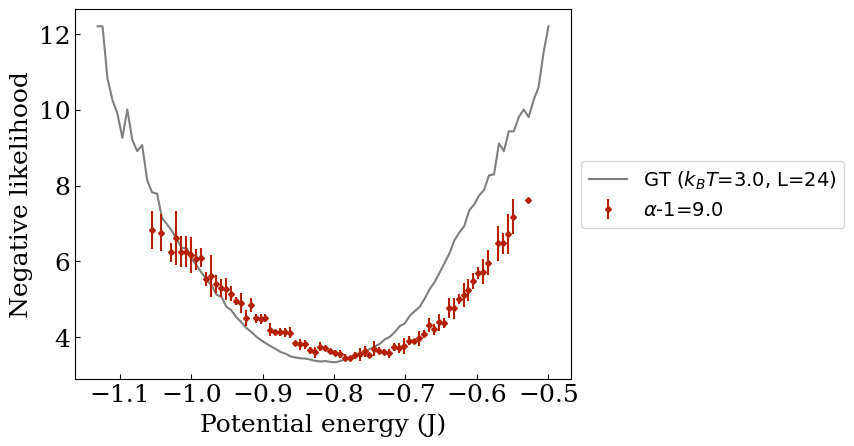

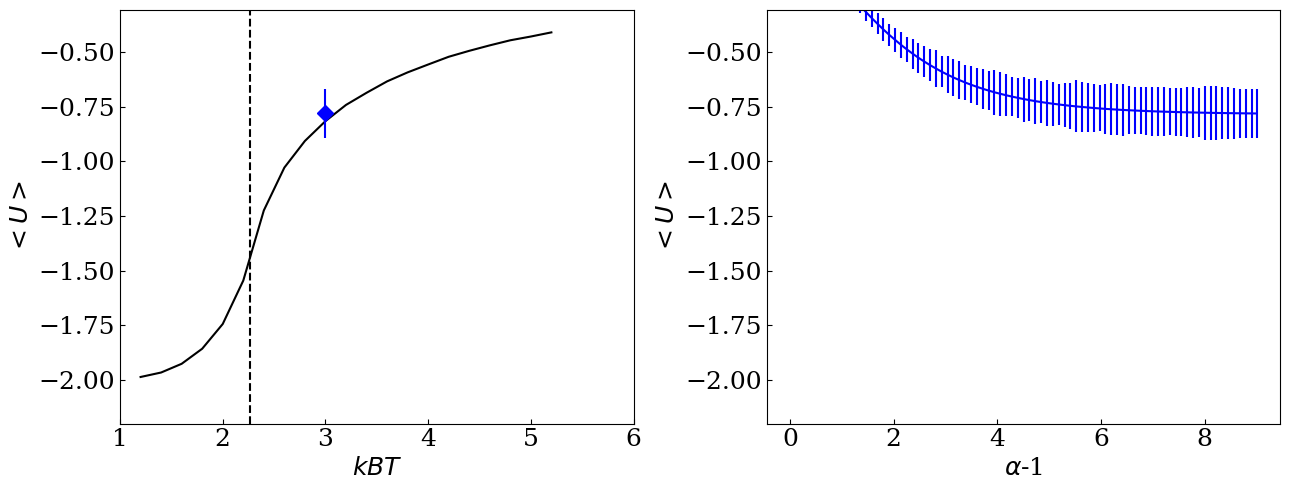

In [70]:
plot_magn(Pred_dict_c5_latt24, Reference_dict_latt24, 24, Reference_Tlist=[3], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c5_latt24, Reference_dict_potE_latt24, 24, Reference_Tlist=[3], diffstep_list=[-1])
plot_expactation_potenergy(Pred_dict_c5_latt24, Expectation_Reference_dict_latt24, 24, Benchmark_T=[3,], Benchmark_diffstep=[-1])

In [71]:
Pred_dict_c5_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm3/tilt0.02/g0/seq_val.npy"
T=3
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.026
Pred_dict_[key]["Predictions"] = Pred_dict_c5_latt24

In [72]:
## Not good!
# Pred_dict_c1_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm3/tilt0.05/g0", (24,24))

Pred_dict_c1_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c1_latt24, difftime_list)

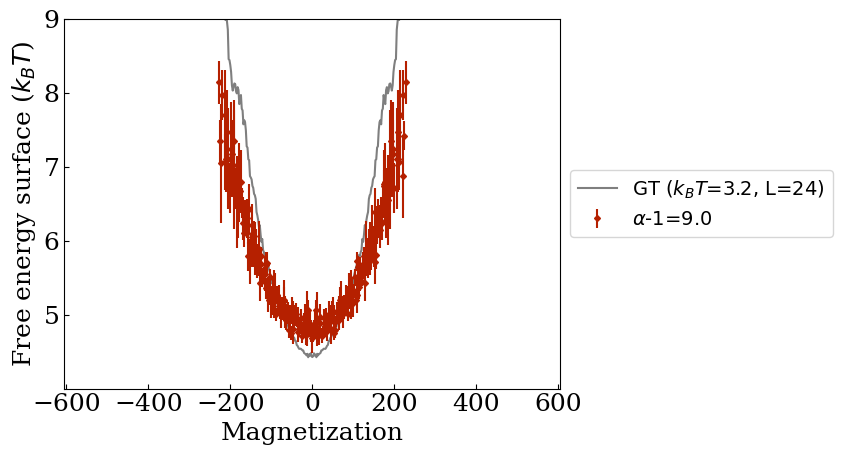

In [73]:
plot_magn(Pred_dict_c1_latt24, Reference_dict_latt24, 24, Reference_Tlist=[3.2], diffstep_list=[-1], ylimit=(None, 9))

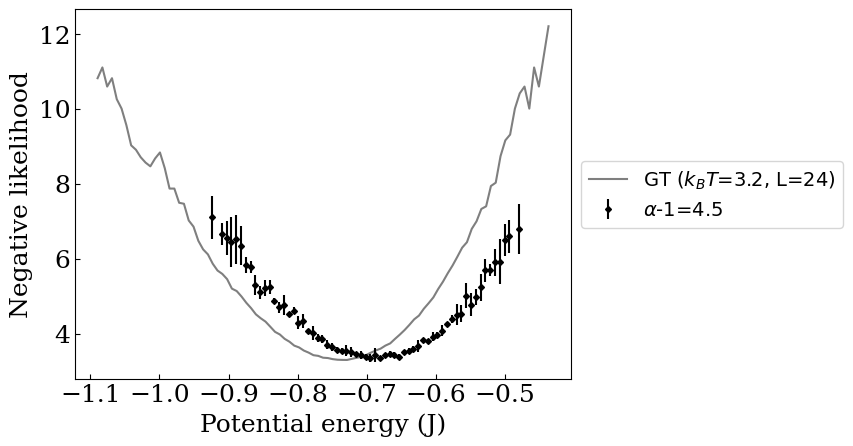

In [106]:
plot_potenergy(Pred_dict_c1_latt24, Reference_dict_potE_latt24, 24, Reference_Tlist=[3.2], diffstep_list=[40])

0.09501650776574494


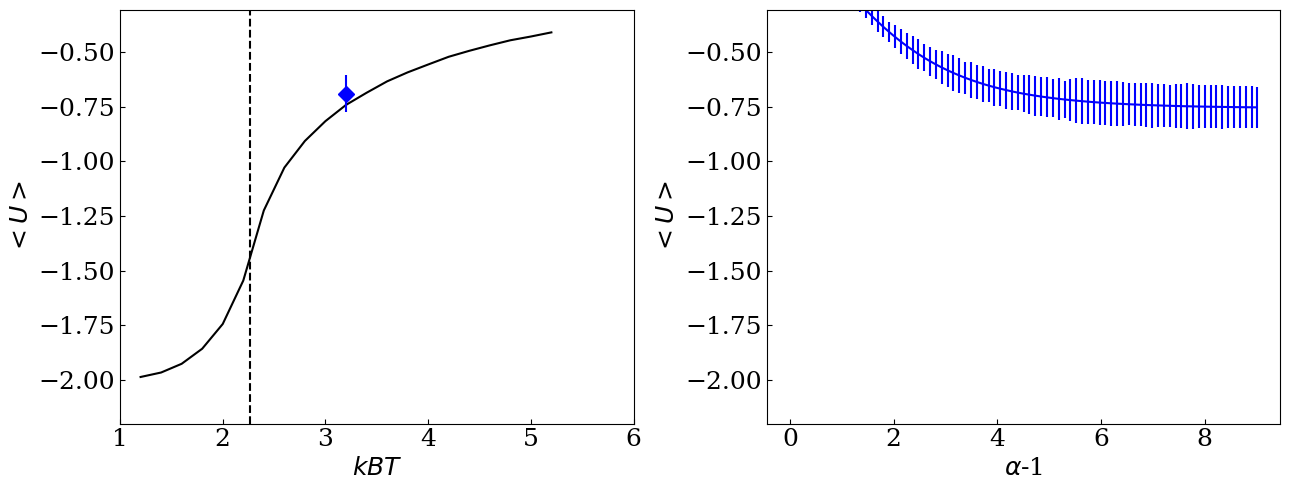

In [105]:
print(Pred_dict_c1_latt24["FlowExpectations-PotE"][-1][2]/24**2)
plot_expactation_potenergy(Pred_dict_c1_latt24, Expectation_Reference_dict_latt24, 24, Benchmark_T=[3.2,], Benchmark_diffstep=[40])

In [74]:
Pred_dict_c1_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0/seq_val.npy"
T=3.2
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = None
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.0
Pred_dict_[key]["Predictions"] = Pred_dict_c1_latt24

In [75]:

Pred_dict_c3_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c3_latt24, difftime_list)

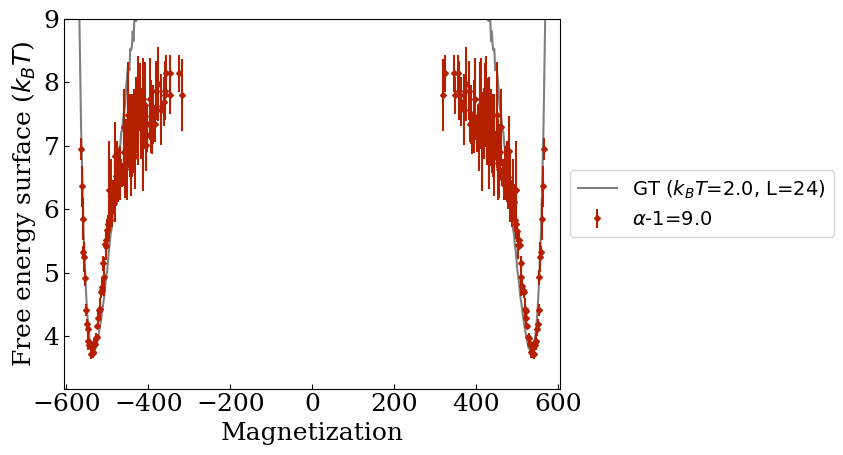

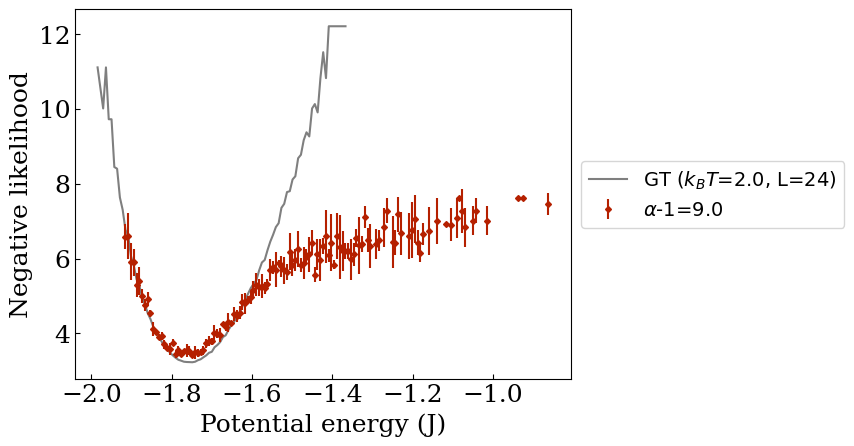

In [76]:
plot_magn(Pred_dict_c3_latt24, Reference_dict_latt24, 24, Reference_Tlist=[2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c3_latt24, Reference_dict_potE_latt24, 24, Reference_Tlist=[2], diffstep_list=[-1])

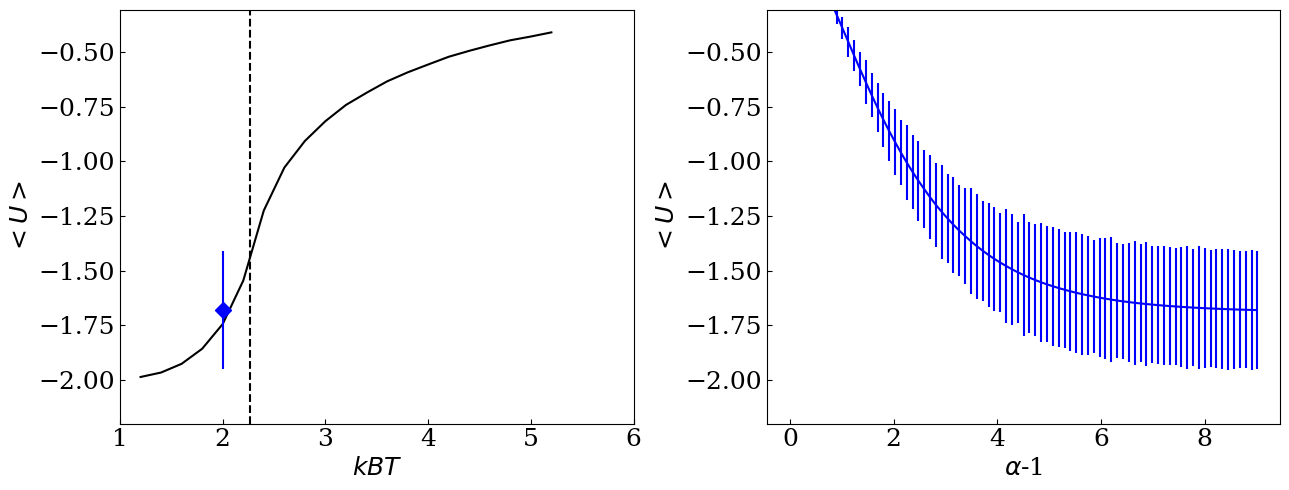

In [78]:
plot_expactation_potenergy(Pred_dict_c3_latt24, Expectation_Reference_dict_latt24, 24, Benchmark_T=[2], Benchmark_diffstep=[-1])

In [77]:
Pred_dict_c3_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.24/g0/seq_val.npy"
T=2
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.2, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.24
Pred_dict_[key]["Predictions"] = Pred_dict_c3_latt24

In [78]:
Pred_dict_c4_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.75/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c4_latt24, difftime_list)

In [79]:
Pred_dict_c4_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.75/g0/seq_val.npy"
T=1
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.8, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.75
Pred_dict_[key]["Predictions"] = Pred_dict_c4_latt24

In [80]:

Pred_dict_c2_latt24, difftime_list = read_prediction("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0", (24,24))
calc_expectation_potenergy(Pred_dict_c2_latt24, difftime_list)

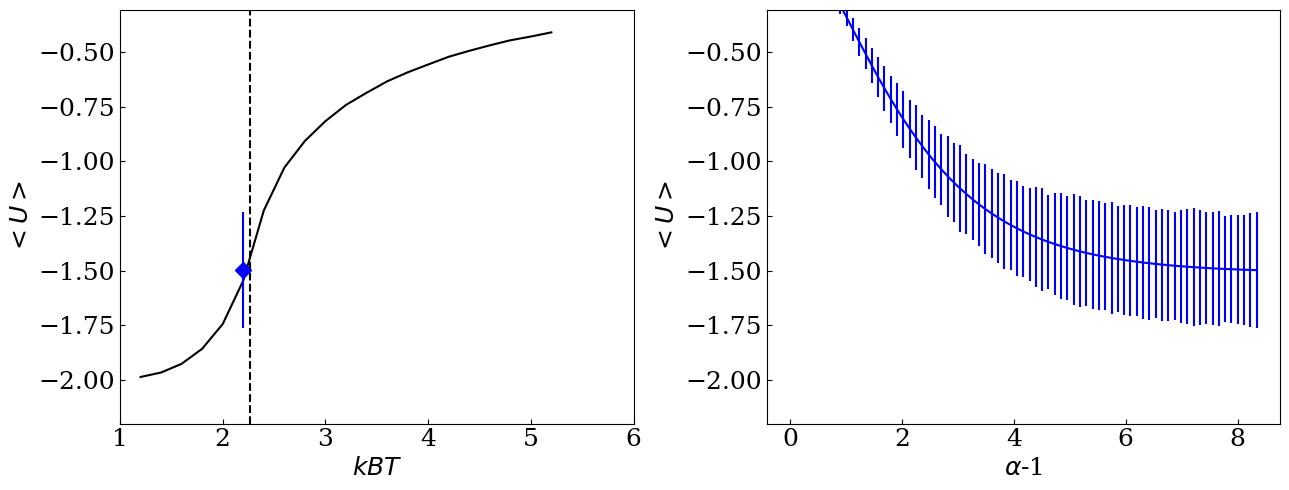

In [83]:
plot_expactation_potenergy(Pred_dict_c2_latt24, Expectation_Reference_dict_latt24, 24, Benchmark_T=[2.2,], Benchmark_diffstep=[-1])

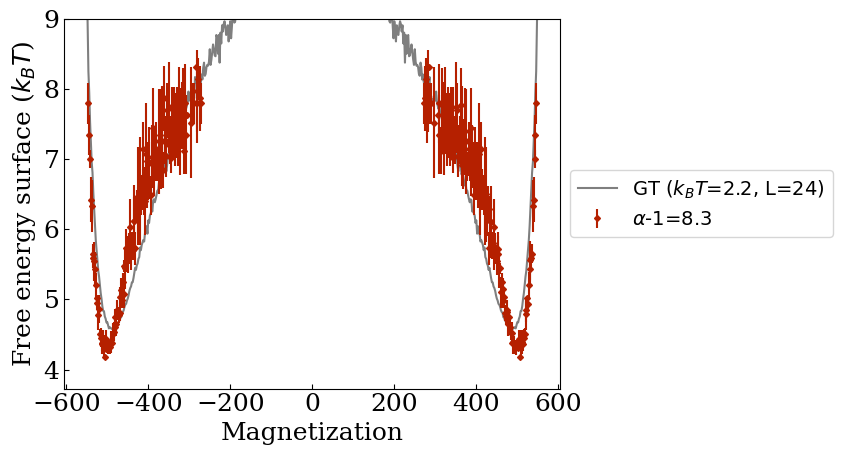

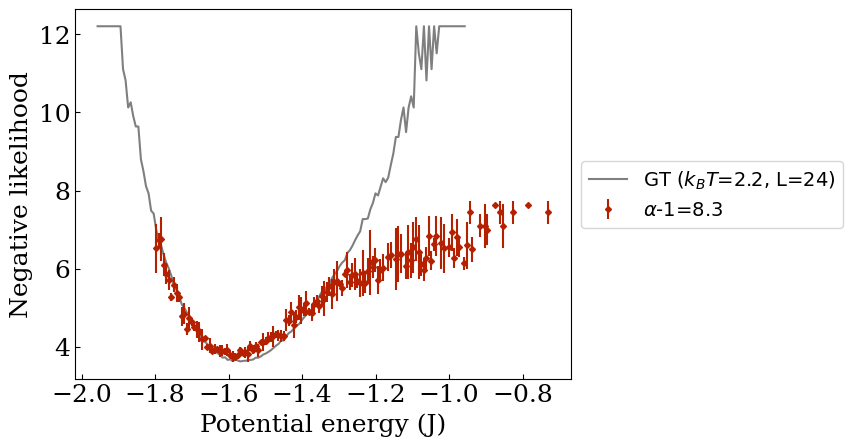

In [84]:
plot_magn(Pred_dict_c2_latt24, Reference_dict_latt24, 24, Reference_Tlist=[2.2], diffstep_list=[-1], ylimit=(None, 9))
plot_potenergy(Pred_dict_c2_latt24, Reference_dict_potE_latt24, 24, Reference_Tlist=[2.2], diffstep_list=[-1])

In [81]:
Pred_dict_c2_latt24["seq_path"] = "val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0/seq_val.npy"
T=2.2
L=24
key="T%.1fL%d"%(T,L)
Pred_dict_[key] = {}
Pred_dict_[key]["guidance_data"] = {"source": "MC", "T": 2.2, "L": 6}
Pred_dict_[key]["shuffle_freq"] = 0.0
Pred_dict_[key]["guidance_coeff"] = 0.18
Pred_dict_[key]["Predictions"] = Pred_dict_c2_latt24

seq.shape =  16384 24 24


/tmp/ipykernel_262212/1143128827.py:26: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-E/kBT)


2497


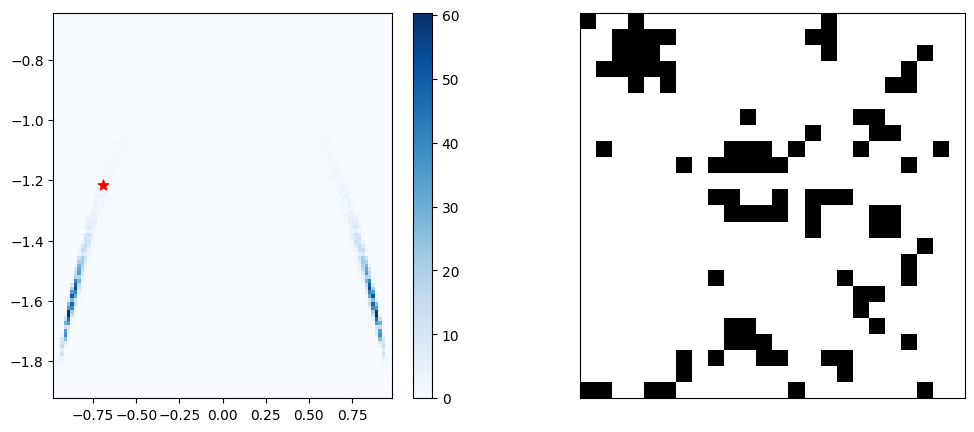

In [86]:
plot_dist("val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0/")

In [82]:
for key in sorted(list(Pred_dict_.keys())):
    print(key, Pred_dict_[key]["guidance_coeff"])

T1.0L24 0.75
T1.2L24 1.0
T1.2L6 1.0
T1.4L24 1.4
T2.0L12 0.24
T2.0L24 0.24
T2.2L24 0.18
T2.2L6 0.24
T2.4L6 0.18
T2.8L6 0.1
T3.0L24 0.026
T3.2L12 0.0
T3.2L24 0.0
T3.2L6 0.0


## Lattice size = 36x36

In [565]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(36,36,36,36)
Reference_dict_latt36 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt36 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))


In [ ]:
Expectation_Reference_dict_latt36 = {}
Expectation_Reference_dict_latt36["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [ ]:
Pred_dict_c1_latt36, difftime_list = read_prediction("clf/guidanceM/val_baseline_latt36x36/epoch159_IntStep80_AMax10_clspd1.0_scoreG1.0_testsymm1", (36,36))

In [ ]:
Pred_dict_latt36, difftime_list = read_prediction("clf/guidanceM/val_baseline_latt36x36/epoch159_IntStep80_AMax10_clspd1.0_scoreG0.0/", (36,36))

In [ ]:
calc_expectation_potenergy(Pred_dict_c1_latt36, difftime_list)
calc_expectation_potenergy(Pred_dict_latt36, difftime_list)

In [ ]:
plot_magn(Pred_dict_c1_latt36, Reference_dict_latt36, 36, Reference_Tlist=[2.4, 2.2, 1.6], ylimit=(None,None))

In [ ]:
plot_potenergy(Pred_dict_c1_latt36, Reference_dict_potE_latt36, 36, Reference_Tlist=[2.4, 2.2, 1.2])

In [ ]:
plot_expactation_potenergy(Pred_dict_c1_latt36, Expectation_Reference_dict_latt36, 36, Benchmark_T=[1.2,], Benchmark_diffstep=[-1])

In [ ]:
plot_magn(Pred_dict_latt36, Reference_dict_latt36, 36, Reference_Tlist=[3.2], ylimit=(None,None))

In [ ]:

plot_expactation_potenergy(Pred_dict_latt36, Expectation_Reference_dict_latt36, 36, Benchmark_T=[3.2,], Benchmark_diffstep=[-1])

In [83]:
import json
from copy import deepcopy
def ndarray_to_list(d_):
    d = deepcopy(d_)
    if isinstance(d, dict):
        # 如果是字典，递归处理每个键
        return {k: ndarray_to_list(v) for k, v in d.items()}
    elif isinstance(d, list):
        # 如果是列表，递归处理每个元素
        return [ndarray_to_list(i) for i in d]
    elif isinstance(d, np.ndarray):
        # 如果是 ndarray，转换为列表
        return d.tolist()
    else:
        # 如果是其他类型，直接返回
        return d

o_Pred_dict_ = ndarray_to_list(Pred_dict_)
with open('Pred_dict.json', 'w', encoding='utf-8') as json_file:
    json.dump(o_Pred_dict_, json_file, ensure_ascii=False, indent=4)
del o_Pred_dict_

## The ground truth

In [ ]:
plt.plot(Expectation_Reference_dict_latt6["PotE"][:,0], Expectation_Reference_dict_latt6["PotE"][:,1]/6**2, c="k")
plt.plot(Expectation_Reference_dict_latt36["PotE"][:,0], Expectation_Reference_dict_latt36["PotE"][:,1]/36**2)